In [5]:
%pip install anytree

Note: you may need to restart the kernel to use updated packages.


In [6]:
import torch
import pickle
from pathlib import Path
import os
import pprint
from anytree import Node, RenderTree
import numpy as np
import matplotlib.pyplot as plt
import tikzplotlib
import scipy 

For future iterations of this I might change the scheme to a deep directory based approach.    
Then iterations would be named `1.pickle`, `2.pickle` and be stored in deep directories like:    
`"Experiment_name/config1/config2/config3/config4/1.pickle"`    
This way I could just split the name accross the folder separator and have all the setting values, then the only thing I need is a list that gives me the correct setting-value assignment, which sounds a lot easier.

# Helper functions

In [7]:
def unpickle(filepath : str):
    file_object = open(filepath, "rb")
    results = pickle.load(file_object)
    file_object.close()
    return results

In [8]:
def extract_setting_from_name(name :str, naming_schema : list):
    result = {}
    # Main assumption for the naming schema: parameters are strictly separated by underscores '_'
    for value, setting in zip(name.split("_"), naming_schema):
        result[setting] = value
    return result
    

In [9]:
def load_results(directory, experiment_name, naming_schema=None, regex_scheme=None):
    path = Path(directory)

    dirs = [e for e in path.iterdir() if e.is_dir() and not str(e) == '.ipynb_checkpoints']
    subdirs = {str(path): [e for e in path.iterdir() if e.is_dir()] for path in dirs}
    
    relevant_subdirs = subdirs[os.path.join(directory, experiment_name)]
    relevant_subdirs.sort()
    #result_filename = '*.pickle'
    pickle_dirs = list()
    for subdir in relevant_subdirs:
        if regex_scheme:
            pickle_dirs.extend(sorted(subdir.glob(regex_scheme)))
        else:
            pickle_dirs.extend(sorted(subdir.glob("*.pickle")))
    results = []
    if not naming_schema is None:
        all_attributes = [extract_setting_from_name(subdir.name, naming_schema) for subdir in relevant_subdirs]    
        for attributes, pick in zip(all_attributes, pickle_dirs):
            try:
                unpickled_stuff = unpickle(pick)
                results.append({'attributes': attributes, 'results': unpickled_stuff})
            except:
                # Sometimes there were unknown issues with the pickle files, in those instances we re-ran training
                print("Catastrophic failure")
    else:
        for pick in pickle_dirs:
            try:
                unpickled_stuff = unpickle(pick)
                results.append({'results': unpickled_stuff})
            except:
                # Sometimes there were unknown issues with the pickle files, in those instances we re-ran training
                print("Catastrophic failure")
    return results


In [10]:
def deep_dict_get(data : dict, path : str):
    """
    path a slash ('/') separated path down to 
    """
    temp = data.copy()
    for entry in path.split("/"):
        # Catches leading '/' in tree printing
        if entry == '':
            continue
        temp = temp[entry]
    return temp

In [11]:
def compare_values(d1 : dict, d2 : dict, path : str):
    v1 = deep_dict_get(d1, path)
    v2 = deep_dict_get(d2, path)
    # Sanity check 1
    if not type(v1) == type(v2):
        return False
    else:
        # This can potentially cause errors when comparing lists of lists (or Tensors/Arrays)
        return v1 == v2

In [12]:
def create_common_root_list(root : str, values : list):
    return [f"{root}/{val}" for val in values]

# Main functions    
What features do I need?    
- ~~Show a structure tree of the results (i.e. experiment settings and result values)~~~
- ~~Filtering by setting, given a key~~
- ~~Filtering by values, given a key~~
- Create selected statistics (mean/med/std/quartiles/...) for certain values/keys
- Apply a function to certain values/keys and return the results (e.g. Eigendecomposition/Normalization/...)
- ~~Group all entries that share settings/values~~
- 

In [13]:
def generate_tree_structure(data, parent=None):
    # Solved through recursively going deeper into the data structure and then returning the leafs if at the end

    if parent is None and not len(data.keys()) == 1:
        parent = Node("root")
    elif parent is None:
        parent = Node(list(data.keys())[0])
        data = data[list(data.keys())[0]]
    
    # Recursion condition
    # If there are any dictionaries inside then go deeper
    if not any([type(data[entry]) == dict for entry in data]):
        for entry in data:
            Node(entry, parent=parent) 
    else:
        for entry in data:
            if type(data[entry]) == dict:
                branch = Node(entry, parent=parent)
                generate_tree_structure(data[entry], parent=branch)
            else:
                Node(entry, parent=parent)
    return parent
    

In [14]:
def group_by(list_of_data : list, path, value=None):
    """
    value : If None, make subgroups of equal values. 
            Otherwise return a single group where value is matched
    """
    grouped_data = {}

    if not value is None:
        grouped_data[f"{path} = {value}"] = [data for data in list_of_data if deep_dict_get(data, path) == value]
    else:    
        finished_values = list()
        for data in list_of_data:
            value = deep_dict_get(data, path)
            if f"{path} = {value}" in grouped_data.keys():
                grouped_data[f"{path} = {value}"].append(data)
            else:
                grouped_data[f"{path} = {value}"] = list()
                grouped_data[f"{path} = {value}"].append(data)
            #if not value in finished_values:
            #    grouped_data[f"{path} = value"] = [data for data in list_of_data if deep_dict_get(data, path) == value]
            #    finished_values.append(value)
    return grouped_data

In [15]:
def dict_compare(d1, d2):
    # Checking for empty list in d2, i.e. initial value
    if not type(d1) == type(d2):
        return False
    return all((d1.get(k) == v for k, v in d2.items()))
        

# Could contain an alternative head as (list_of_data : list, paths : [list, dict], values : None) 
# where paths-values would require a 1-to-1 correspondence. 
# But this could quickly become error prone on the user side...
def group_by_multiple(list_of_data : list, paths):
    grouped_data = {}
    # Grouping without values
    if type(paths) == list:
        finished_values = list()
        for data in list_of_data:
            paths_vals = {path : deep_dict_get(data, path) for path in paths}
            # not any X <=> all not X
            # i.e. only succeeds when this combination didn't exist before
            if not any([dict_comapare(paths_vals, fin_val) for fin_val in finished_values]):
                grouped_data[" ; ".join([f"{path} = {paths_vals[path]}" for path in paths_vals])] = [data]
            else:
                grouped_data[" ; ".join([f"{path} = {paths_vals[path]}" for path in paths_vals])].append(data)

    # Grouping by path-value combinations
    # Only returns the group where all those pairs are true
    elif type(paths) == dict:
        # The keys will contain the paths
        # The values will be the corresponding expected values
        # Yes, this could be a one-liner with a very neat nested list creation, 
        #  but I chose readability with temporary variables over it.
        good_data = list()
        for data in list_of_data:
            if all([deep_dict_get(data, path) == paths[path] for path in paths]):
                good_data.append(data)
        grouped_data[" ; ".join([f"{path} = {paths[path]}" for path in paths])] = good_data
    return grouped_data

In [16]:
def filter_by(list_of_data : list, path : str, value):
    filtered_data = list()
    for data in list_of_data:
        if deep_dict_get(data, path) == value:
            filtered_data.append(data)
    return filtered_data

In [17]:
def filter_value(list_of_data : list, path : str):
    """
        returns a list of the target value from each data dict
    """
    list_of_values = list()
    for data in list_of_data:
        list_of_values.append(deep_dict_get(data, path))
    return list_of_values

# Things I want to check
 - **Hardcoded setting**: Do the metrics have the same order as MCMC?
 - **CO2**: Also check the order
 - **CO2**: Check the prediction of future datapoints for each favourite metric 
 - **Kernel search**: How do the kernels found by the metrics perform according to MCMC?
 - (Kernel search: How do the kernels found by the metrics predict the future datapoints?)
 - **LODE**: Does Laplace find the most appropriate Differential equation? I.e. the correct numbers of parameters?

# Load results

In [16]:
all_results = load_results('results', "hardcoded", regex_scheme="results.pickle")
#all_results = load_results('results_pre_vacation/results', "hardcoded", regex_scheme="results.pickle")
#all_results = load_results('results_small_experiment', "hardcoded45", regex_scheme="results.pickle")

postfix = ""
result_tree = generate_tree_structure(all_results[0]).descendants

In [17]:
# Combining two different seeds
# Look for the exact same set of attributes and append the corresponding runs to the first result list
import copy
def combine_results(main_results, other_results):
    """
        main_results : If the result lists are of different size (in terms of the settings), this list is the one containing the larger set of settings
        other_results: This is the list of results added to the other
    """
    return_results = copy.deepcopy(main_results)
    for main_dict in main_results:
        # Check for these two 
        data_gen_kernel = main_dict["results"]["attributes"]["data_gen"]
        dataset_size = main_dict["results"]["attributes"]["eval_COUNT"]


In [18]:
all_results[0]["results"]["attributes"].keys()#["results"][0]["Laplace"]["PER"].keys()#["results"][2]#.keys()#["Laplace"].keys()

dict_keys(['eval_START', 'eval_END', 'eval_COUNT', 'optimizer', 'train_iters', 'LR', 'BFGS', 'data_gen'])

In [19]:
#TODO filter welcher Datengenerierende Kern größere/kleinere Korrelationen zu MCMC hat
# Irgendwo da werden sich Fehler befinden
# TODO Gibt's einen Korrelationsunterschied bei mehr/weniger Datenpunkten
# TODO Guck dir die MCMC/MLL Werte an, irgendwo ist da noch ein Rechenfehler


# Hardcoded results

In [20]:
#naming_schema = ["Metric", "Kernel_search", "train_data_ratio", "Data_kernel", "weights", "Variance_list", "eval_START", "eval_END", "eval_COUNT", "optimizer", "train_iterations", "LR", "Noise", "Data_scaling", "BFGS"]
#all_results = load_results('results', "hardcoded", regex_scheme="results.pickle")
#
#postfix = ""
#result_tree = generate_tree_structure(all_results[0]).descendants


# What do I want to know?
# 1.) Does each metric recognize the correct kernels?
# 1.1.) If not: Why?
# 2.) Is the order I was talking about true?
# 2.1.) i.e. MLL > Laplace/AIC >=? MCMC
# 3.) Are models with redundant parameters more punished than others? Especially the 2SIN vs 3SIN case
# 4.) Make a ranking sheet per dataset where the models are compared _within_ a metric to see if there are similarities visible or something
#  
model_kernels = ["SE", "SE+SE", "MAT32"]
model_kernels = ["LIN*SE", "LIN*PER", "SE", "SE+SE", "MAT32", "LIN"]
#model_kernels = ["PER", "PER*SE", "SE", "MAT32", "MAT32+SE", "MAT32*SE"]
data_kernels = ["SE", "SE+SE", "LIN"]
#data_kernels = ["SE", "RQ", "MAT32", "MAT52", "SE*SE",
#               "SE+SE", "MAT32+SE", "MAT52+SE", "MAT32*SE", "PER",
#               "PER*SE", "(SE+RQ)*PER", "SE+SE+SE", "MAT32+(MAT52*PER)"]
dataset_sizes = [5, 10, 20]#, 10, 20, 30, 50, 70, 100]#, 10, 20, 30, 50, 70, 100]
#data_kernels = ["MAT52", "RQ", "SE", "MAT32", "SE*SE"]
#dataset_sizes = [5, 10, 20, 30, 50, 70, 100]#[5, 10, 20, 30, 50, 70, 100, 150, 200]
metrics = ["Nested", "AIC", "BIC", "MLL", "MAP",  {"Laplace": [0.0, -1.0, "BIC"]}]#"MC",  
#dataset_sizes = [5, 10, 20, 30, 50, 70, 100, 150, 200] 
data_model_zip = zip(data_kernels, model_kernels)




print("1.) How far away (by varying metrics) is each metric to MCMC?")

all_replaced_dict = {-1.0: list(), 0.0: list(), "BIC": list()} 
# Iterate over all datasets
mcmc_closeness_dict = {data_gen_kernel:{datasize:list() for datasize in dataset_sizes} for data_gen_kernel in data_kernels}
mcmc_ranking_dict = {data_gen_kernel:{datasize:list() for datasize in dataset_sizes} for data_gen_kernel in data_kernels}
for main_dict in all_results:
    data_gen_kernel = main_dict["results"]["attributes"]["data_gen"]
    dataset_size = main_dict["results"]["attributes"]["eval_COUNT"]
    if any([2.0 in main_dict["results"]["results"][0]["Laplace"][model_kernel].keys() for model_kernel in main_dict["results"]["results"][0]["Laplace"].keys()]):
        print("This happened")
        print(dataset_size)
        continue
    for run in main_dict["results"]["results"]:
        run_list = dict()
        ranking_list = dict()
        # Do this comparison for each model kernel
        for metric in metrics:
            intra_metric_ranking = list()
            if isinstance(metric, dict):
                metric_name = list(metric.keys())[0]
                for threshold in metric[metric_name]:
                    intra_metric_ranking = list()
                    for model_kernel in model_kernels:
                        all_replaced = run[metric_name][model_kernel][threshold]["details"]['num_replaced'] == len(run[metric_name][model_kernel][threshold]["details"]['parameter list'])
                        all_replaced_dict[threshold].append(all_replaced)
                        intra_metric_ranking.append((run[metric_name][model_kernel][threshold]['loss'], f"{model_kernel}"))
                    ## For ranking
                    ranking_list[f"{metric_name}_{threshold}"] = sorted(intra_metric_ranking, key=lambda x:x[0], reverse=True)   
                    # For model evidence
                    run_list[f"{metric_name}_{threshold}"] = intra_metric_ranking
            else:
                for model_kernel in model_kernels:
                    if metric in ["AIC", "BIC"]:
                        intra_metric_ranking.append((-run[metric][model_kernel]['loss'], model_kernel))
                    else:
                        intra_metric_ranking.append((run[metric][model_kernel]['loss'], model_kernel))
                # For ranking
                ranking_list[metric] = sorted(intra_metric_ranking, key=lambda x:x[0], reverse=True )
                # For model evidence
                run_list[metric] = intra_metric_ranking
        mcmc_closeness_dict[data_gen_kernel][dataset_size].append(run_list)
        mcmc_ranking_dict[data_gen_kernel][dataset_size].append(ranking_list)


with open("evaluation/temp_storage/mcmc_closeness_dict.pickle", "wb") as f:
    pickle.dump(mcmc_closeness_dict, f)


print("1.) Does each metric recognize the correct kernel? (hardcoded)")
# 1.) Does each metric recognize the correct kernel?
# Iterate over all datasets
str_metrics = ["Nested", "AIC", "BIC", "MLL", "MAP", "Laplace_0.0", "Laplace_-1.0", "Laplace_BIC"]# "MC"
results_table = {datasize: {f"{metric}{postfix}":{"RR": list(), "RR3":list(), "runtime": -1} for metric in str_metrics} for datasize in dataset_sizes} 
#for main_dict in all_results:
# Iterate over all kernels I tried
#for model_kernel in ['C*C*RBF','C*RBF','C*SIN','C*SIN + C*SIN','C*SIN + C*SIN + C*SIN','SIN*RBF']:
#print(main_dict["results"]["attributes"]["data_gen"])
mcmc_confusion_data = {data_kernel: {model_kernel for model_kernel in model_kernels}  for data_kernel in data_kernels}
mcmc_confuse_number = 20
for data_num in dataset_sizes:
    # Filter for dataset size
    data_500 = group_by_multiple(all_results, {'/results/attributes/eval_COUNT': data_num})
    data_500_key = list(data_500.keys())[0]

    for result in data_500[data_500_key]:
        if not deep_dict_get(result, "results/attributes/data_gen") in data_kernels or not deep_dict_get(result, "results/attributes/data_gen") in model_kernels:
            continue
        for metric in metrics:
            if type(metric) == dict:
                for threshold in metric[list(metric.keys())[0]]:
                    metric_str = f"{list(metric.keys())[0]}_{str(threshold)}"
                    for run_num in range(len(result["results"]["results"])):
                        if result["results"]["attributes"]["data_gen"] == max([(result['results']['results'][run_num]['Laplace'][model_kernel][threshold]['loss'], model_kernel) for model_kernel in model_kernels])[-1]:
                            results_table[data_num][f"{metric_str}{postfix}"]["RR"].append(True)
                        else:
                            results_table[data_num][f"{metric_str}{postfix}"]["RR"].append(False)
                        sorted_results = sorted([(result['results']['results'][run_num]['Laplace'][model_kernel][threshold]['loss'], model_kernel) for model_kernel in model_kernels], key=lambda x:x[0], reverse=True)
                        top3 = sorted_results[:3]#sorted([(result['results'][metric][model_kernel]['loss'], model_kernel) for model_kernel in model_kernels])[:3]
                        if result["results"]["attributes"]["data_gen"] in [t[1] for t in top3]:
                            results_table[data_num][f"{metric_str}{postfix}"]["RR3"].append(True)
                        else:
                            results_table[data_num][f"{metric_str}{postfix}"]["RR3"].append(False)
            else:
                #if metric == "MC" and data_num == mcmc_confuse_number:
                #    for model_kernel in model_kernels:
                #        mcmc_confusion_data[result["results"]["attributes"]["data_gen"]][model_kernel] = result['results']['results'][run_num][metric][model_kernel]['loss']
                for run_num in range(len(result["results"]["results"])):
                    if result["results"]["attributes"]["data_gen"] == max([(result['results']['results'][run_num][metric][model_kernel]['loss'], model_kernel) for model_kernel in model_kernels])[-1]:
                        results_table[data_num][f"{metric}{postfix}"]["RR"].append(True)
                    else:
                        results_table[data_num][f"{metric}{postfix}"]["RR"].append(False)
                    sorted_results = sorted([(result['results']['results'][run_num][metric][model_kernel]['loss'], model_kernel) for model_kernel in model_kernels], key=lambda x:x[0], reverse=True)
                    top3 = sorted_results[:3]#sorted([(result['results'][metric][model_kernel]['loss'], model_kernel) for model_kernel in model_kernels])[:3]
                    if result["results"]["attributes"]["data_gen"] in [t[1] for t in top3]:
                        results_table[data_num][f"{metric}{postfix}"]["RR3"].append(True)
                    else:
                        results_table[data_num][f"{metric}{postfix}"]["RR3"].append(False)
    #print(f"{metric}\t {max([(main_dict['results'][metric][model_kernel]['loss'], model_kernel) for model_kernel in model_kernels])}")

print("2.) Test likelihood of the models? (hardcoded)")

str_metrics = ["Nested", "AIC", "BIC", "MLL", "MAP", "Laplace_0.0", "Laplace_-1.0", "Laplace_BIC"]# "MC"
test_likelihood_results_table = {datasize: {f"{metric}{postfix}":{"Test Likelihood": list()} for metric in str_metrics} for datasize in dataset_sizes} 

# Iterate over all runs and store the test likelihood in the results table
for main_dict in all_results:
    data_gen_kernel = main_dict["results"]["attributes"]["data_gen"]
    dataset_size = main_dict["results"]["attributes"]["eval_COUNT"]
    for run in main_dict["results"]["results"]:
        run_list = dict()
        ranking_list = dict()
        # Do this comparison for each model kernel
        for metric in metrics:
            if isinstance(metric, dict):
                metric_name = list(metric.keys())[0]
                for threshold in metric[metric_name]:
                    intra_metric_ranking = list()
                    for model_kernel in model_kernels:
                        intra_metric_ranking.append((run[metric_name][model_kernel][threshold]['loss'], f"{model_kernel}"))
                    # best model kernel according to the metric
                    # Returns the model kernel name
                    best_model_kernel = max(intra_metric_ranking, key=lambda x:x[0])[1]
                    test_likelihood_results_table[dataset_size][f"{metric_name}_{threshold}"]["Test Likelihood"].append(run["test likelihood(MAP)"][best_model_kernel])
            else:
                intra_metric_ranking = list()
                for model_kernel in model_kernels:
                    intra_metric_ranking.append((run[metric][model_kernel]['loss'], f"{model_kernel}"))
                # best model kernel according to the metric
                # Returns the model kernel name
                best_model_kernel = max(intra_metric_ranking, key=lambda x:x[0])[1]
                if metric == "MAP":
                    test_likelihood_results_table[dataset_size][metric]["Test Likelihood"].append(run["test likelihood(MAP)"][best_model_kernel])
                else:
                    test_likelihood_results_table[dataset_size][metric]["Test Likelihood"].append(run["test likelihood"][best_model_kernel])

                test_likelihood_results_table[dataset_size][metric]["Test Likelihood"].append(max([run[metric][model_kernel]['loss'] for model_kernel in model_kernels]))


"""
print("===============================")
print("2.) Is the order I was talking about true? i.e. what is the order or the values for MLL, AIC, Laplace and where does MC lie at?")
# 2.) Is the order I was talking about true? i.e. what is the order or the values for MLL, AIC, Laplace and where does MC lie at?
#     It should be ordered AIC > MLL > Laplace
#     And somewhere in between there should be MC
# Iterate over all datasets
for main_dict in all_results:
    print(main_dict["results"]["attributes"]["data_gen"])
    # Do this comparison for each model kernel
    #["SE", "PER", "MAT32", "PER*SE", "PER+SE", "MAT32*PER", "MAT32+PER", "MAT32+SE", "MAT32*SE"]
    for model_kernel in model_kernels:
        ranking = [(main_dict['results'][metric][model_kernel]['loss'], metric) for metric in metrics]
        ranking = sorted(ranking, key=lambda x:x[0], reverse=True)
        # Check if it either is MLL > Laplace > AIC (this happens if MLL is negative) OR AIC > MLL > Laplace 
        #if not (main_dict['results']["MLL"][model_kernel]['loss'] > main_dict['results']["Laplace"][model_kernel]['loss'] > main_dict['results']["AIC"][model_kernel]['loss']) and not (main_dict['results']["AIC"][model_kernel]['loss'] > main_dict['results']["MLL"][model_kernel]['loss'] > main_dict['results']["Laplace"][model_kernel]['loss']) :
        print(f"{model_kernel}\t {ranking}")

#print("===============================")
#print("3.) Are models with redundant parameters more punished than others? Especially the 2SIN vs 3SIN case")
## 3.) Are models with redundant parameters more punished than others? Especially the 2SIN vs 3SIN case 
#
## Iterate over all datasets
#for main_dict in all_results:
#    for metric in ["Laplace", "AIC", "Laplace_prior"]:
#        print(metric)
#        for pair in data_model_zip:#[('C*RBF', 'C*C*RBF'), ('C*SIN', 'C*SIN + C*SIN + C*SIN'), ('C*SIN + C*SIN', 'C*SIN + C*SIN + C*SIN'), ('C*SIN', 'C*SIN + C*SIN')]:
#            met_1 = main_dict['results'][metric][pair[0]]['loss'] 
#            met_2 = main_dict['results'][metric][pair[1]]['loss'] 
#            if not met_1 > met_2:
#                print(f"{main_dict['results']['attributes']['data_gen']} \t - {pair}")
        

print("===============================")
print("4.) Make a ranking per dataset how each model kernel was rated")

# 4.) Make a ranking per dataset how each model kernel was rated 
# Iterate over all datasets
confusion_matrix_data = {datasize: {f"{metric}{postfix}":{data_kernel : None for data_kernel in data_kernels} for metric in metrics} for datasize in dataset_sizes} 
for data_num in dataset_sizes:
    print(data_num)
    # Filter for dataset size
    data_500 = group_by_multiple(all_results, {'/results/attributes/eval_COUNT': data_num})
    data_500_key = list(data_500.keys())[0]

    for result in data_500[data_500_key]:
        print(result["results"]["attributes"]["data_gen"])
        for metric in metrics:
        # Do this ranking for each metric 
            print(metric)
            ranking = [(result['results'][metric][model_kernel]['loss'], model_kernel) for model_kernel in model_kernels] 
            key_fkt = lambda x: x[0]
            pprint.pprint(sorted(ranking, key=key_fkt, reverse=True))

            def div2(input, doit):
                if doit:
                    return input/2
                else:
                    return input

            confusion_matrix_data[data_num][f"{metric}{postfix}"][result["results"]["attributes"]["data_gen"]] = [div2(result['results'][metric][model_kernel]['loss'].item(), metric in ["AIC", "BIC"]) for model_kernel in model_kernels]
            print("===============")

print("===============================")
print("5.) Runtime of each metric")

# Do this ranking for each metric 
for data_num in dataset_sizes:
    # Filter for dataset size
    data_500 = group_by_multiple(all_results, {'/results/attributes/eval_COUNT': data_num})
    data_500_key = list(data_500.keys())[0]

    for result in data_500[data_500_key]:
        for metric in metrics:
            #print(metric)
            if metric in ["Laplace", "Laplace_prior", "BIC"]:
                runtime_list = [result['results'][metric][model_kernel]['details']['Total time'] + result['results'][metric][model_kernel]['Train time']  for model_kernel in model_kernels]
            elif metric in ["MLL", "MAP"]:
                runtime_list = [result['results'][metric][model_kernel]['Train time']  for model_kernel in model_kernels]
            else:
                runtime_list = [result['results'][metric][model_kernel]['details']['Total time'] for model_kernel in model_kernels] 
            results_table[data_num][metric]["runtime"] = np.average(runtime_list)

"""

1.) How far away (by varying metrics) is each metric to MCMC?
1.) Does each metric recognize the correct kernel? (hardcoded)
2.) Test likelihood of the models? (hardcoded)


'\nprint("===============================")\nprint("2.) Is the order I was talking about true? i.e. what is the order or the values for MLL, AIC, Laplace and where does MC lie at?")\n# 2.) Is the order I was talking about true? i.e. what is the order or the values for MLL, AIC, Laplace and where does MC lie at?\n#     It should be ordered AIC > MLL > Laplace\n#     And somewhere in between there should be MC\n# Iterate over all datasets\nfor main_dict in all_results:\n    print(main_dict["results"]["attributes"]["data_gen"])\n    # Do this comparison for each model kernel\n    #["SE", "PER", "MAT32", "PER*SE", "PER+SE", "MAT32*PER", "MAT32+PER", "MAT32+SE", "MAT32*SE"]\n    for model_kernel in model_kernels:\n        ranking = [(main_dict[\'results\'][metric][model_kernel][\'loss\'], metric) for metric in metrics]\n        ranking = sorted(ranking, key=lambda x:x[0], reverse=True)\n        # Check if it either is MLL > Laplace > AIC (this happens if MLL is negative) OR AIC > MLL > Lapl

In [21]:
# dataset_sizes
# str_metrics
# ["RR", "RR3", "runtime"]

# RR table
print("RR Table")
main_row_str = ' \t& '.join(str_metrics)
print(f"Data size \t& {main_row_str}")
for dataset_size in dataset_sizes:
    last_len = 0
    row_str = f"{dataset_size}\t" 
    for metric in str_metrics:
        try:
            row_str += f" \t& {round(results_table[dataset_size][metric]['RR'].count(True)/len(results_table[dataset_size][metric]['RR']), 2)}"
        except:
            print(dataset_size)
            print(metric)
        # sanity check
        if last_len == 0:
            last_len = results_table[dataset_size][metric]['RR'].count(True) + results_table[dataset_size][metric]['RR'].count(False)
        elif not last_len == results_table[dataset_size][metric]['RR'].count(True) + results_table[dataset_size][metric]['RR'].count(False):
            print("Error")
    print(row_str)

print("")
# RR3 table
print("RR3 Table")
main_row_str = ' \t& '.join(str_metrics)
print(f"Data size \t& {main_row_str}")
for dataset_size in dataset_sizes:
    last_len = 0
    row_str = f"{dataset_size}\t" 
    for metric in str_metrics:
        row_str += f" \t& {round(results_table[dataset_size][metric]['RR3'].count(True)/len(results_table[dataset_size][metric]['RR3']), 2)}"
        # sanity check
        if last_len == 0:
            last_len = results_table[dataset_size][metric]['RR3'].count(True) + results_table[dataset_size][metric]['RR3'].count(False)
        elif not last_len == results_table[dataset_size][metric]['RR3'].count(True) + results_table[dataset_size][metric]['RR3'].count(False):
            print("Error")
    print(row_str)



#results_table[5]["MC"]["RR"].count(True)
#results_table[5]["MC"]["RR"].count(False)

RR Table
Data size 	& Nested 	& AIC 	& BIC 	& MLL 	& MAP 	& Laplace_0.0 	& Laplace_-1.0 	& Laplace_BIC
5	 	& 0.4 	& 0.33 	& 0.27 	& 0.2 	& 0.6 	& 0.6 	& 0.6 	& 0.6
10	 	& 0.33 	& 0.27 	& 0.27 	& 0.2 	& 0.53 	& 0.53 	& 0.53 	& 0.53
20	 	& 0.6 	& 1.0 	& 1.0 	& 0.4 	& 1.0 	& 1.0 	& 1.0 	& 1.0

RR3 Table
Data size 	& Nested 	& AIC 	& BIC 	& MLL 	& MAP 	& Laplace_0.0 	& Laplace_-1.0 	& Laplace_BIC
5	 	& 0.93 	& 0.73 	& 0.73 	& 0.6 	& 0.8 	& 0.8 	& 0.67 	& 0.67
10	 	& 0.8 	& 0.67 	& 0.73 	& 0.6 	& 0.6 	& 0.67 	& 0.6 	& 0.6
20	 	& 0.8 	& 1.0 	& 1.0 	& 1.0 	& 1.0 	& 1.0 	& 1.0 	& 1.0


## Exploration into results (Stichprobenartig überprüfen ob Ergebnisse Sinn ergeben)
__Was will ich sehen?__
- Stimmen die Reihenfolgen (Rankings) überein mit den Werten der einzelnen Metriken?
- Ergeben die Reihenfolgen Sinn, die die Metriken produzieren? SE ~= MAT32 > SE+SE > LIN oder so ähnlich?
- Wie sehen die Daten aus? Wie sehen die Modelle aus? Ergibt das Sinn, dass die gut/schlecht bewertet werden? Schau dir die Plots an!
- 
#TODO Mehr Ergebnisse _in_ die Plots schreiben. Posterior Plots mit ihren zugehörigen Metrikwerten nach MCMC, AIC, ...


In [22]:
# Exploration helper
def show_data_gen(result):
    return result["results"]["attributes"]["data_gen"]

def show_data_count(result):
    return result["results"]["attributes"]["eval_COUNT"]

def show_metric_results(result, metric, experiment=0):
    # The 0 here is the experiment repitition
    #result["results"]["results"][0]["MC"]["SE"]["details"]
    return result["results"]["results"][experiment][metric]

def show_metric_results_for_kernel(result, metric, kernel, experiment=0):
    return show_metric_results(result, metric, experiment)[kernel]

def show_model_parameters(result, metric, kernel, experiment=0, threshold=0.0):
    if metric == "Laplace":
        return show_metric_results_for_kernel(result, metric, kernel, experiment)[threshold]["details"]["parameter list"]
    return show_metric_results_for_kernel(result, metric, kernel, experiment)["details"]["parameter list"]


In [23]:
print(f"Lap: {show_metric_results_for_kernel(all_results[0], 'Laplace', 'SE')[0.0]['details']['likelihood approximation']}")
print(f"num replaced: {show_metric_results_for_kernel(all_results[0], 'Laplace', 'SE')[0.0]['details']['num_replaced']}")
print(f"Lap: {show_metric_results_for_kernel(all_results[0], 'Laplace', 'SE')[-1.0]['details']['likelihood approximation']}")
print(f"num replaced: {show_metric_results_for_kernel(all_results[0], 'Laplace', 'SE')[-1.0]['details']['num_replaced']}")

Lap: -10.459123430239911
num replaced: 2
Lap: -12.459123430239911
num replaced: 2


In [24]:
#print(show_metric_results_for_kernel(all_results[0], "Laplace", "SE")[0.0]["details"])
print("SE")
print(f"MLL: {show_metric_results_for_kernel(all_results[0], 'Laplace', 'SE')[0.0]['details']['neg MLL']}")
print(f"Parameter values: {show_metric_results_for_kernel(all_results[0], 'Laplace', 'SE')[0.0]['details']['parameter values']}")
print(f"prior mean: {show_metric_results_for_kernel(all_results[0], 'Laplace', 'SE')[0.0]['details']['prior mean']}")
print(f"prior variance (diag): {show_metric_results_for_kernel(all_results[0], 'Laplace', 'SE')[0.0]['details']['diag(prior var)']}")
#print(show_metric_results_for_kernel(all_results[0], "Laplace", "MAT32")[0.0]["details"])
print("MAT32")
print(f"MLL: {show_metric_results_for_kernel(all_results[0], 'Laplace', 'MAT32')[0.0]['details']['neg MLL']}")
print(f"Parameter values: {show_metric_results_for_kernel(all_results[0], 'Laplace', 'MAT32')[0.0]['details']['parameter values']}")
print(f"prior mean: {show_metric_results_for_kernel(all_results[0], 'Laplace', 'MAT32')[0.0]['details']['prior mean']}")
print(f"prior variance (diag): {show_metric_results_for_kernel(all_results[0], 'Laplace', 'MAT32')[0.0]['details']['diag(prior var)']}")

SE
MLL: 10.459046363830566
Parameter values: tensor([[-2.1776],
        [ 1.6609]])
prior mean: tensor([[-3.5164],
        [-0.2122]], dtype=torch.float64)
prior variance (diag): tensor([12.8388,  3.5704], dtype=torch.float64)
MAT32
MLL: 10.383295059204102
Parameter values: tensor([[-2.1650],
        [ 3.3933]])
prior mean: tensor([[-3.5164],
        [ 1.5711]], dtype=torch.float64)
prior variance (diag): tensor([12.8388,  5.9799], dtype=torch.float64)


In [25]:
# all starts with "all_results"
# How to orient myself in the list?
# It is a list of all "dataset_size"-"generating kernel" combinations in arbitrary order
# Establish the current dataset size and generating kernel
run_number = 0
print(show_data_count(all_results[run_number]))
print(show_data_gen(all_results[run_number]))
print("-------")
# All metrics share the same dataset (and therefore similar model) in one experiment
#show_metric_results(all_results[run_number], "Laplace", experiment=1)["SE"][0.0]["loss"]
# For AIC/BIC: smaller = better
# For everything else: larger = better
# In our experiments we have 3 model kernels: "SE", "SE+SE", "MAT32"
model_kernels = ["SE", "SE+SE", "MAT32"]
#metrics = ["MC", "AIC", "BIC", "MLL", "MAP",  {"Laplace": [0.0, -1.0, "BIC"]}] 
experiment_number = 0
for model_kernel in model_kernels:
    print(f"\t{model_kernel}")
    for metric in ["Nested", "MAP", "MLL", {"Laplace": [0.0, -1.0, "BIC"]}]:#"MC"
        loss_list = list()
        if type(metric) is dict:
            metric_str = list(metric.keys())[0]
            for threshold in [0.0, -1.0, "BIC"]:
                loss_list = list()
                #for experiment in range(experiment_number, experiment_number+1):
                for experiment in range(5):
                    curr_results = show_metric_results_for_kernel(all_results[run_number], metric_str, model_kernel, experiment=experiment)
                    #print(f"{metric_str[:3]}_{threshold} \t: {curr_results[threshold]['loss']:.2f}")
                    loss_list.append(curr_results[threshold]['loss'].item())
                    #print(show_model_parameters(all_results[run_number], metric_str, model_kernel, experiment=experiment, threshold=threshold))
                print(f"{metric_str}_{threshold} average: {np.average(loss_list):.2f}")
        else:
            metric_str = metric 
            #for experiment in range(experiment_number, experiment_number+1):
            for experiment in range(5):
                curr_results = show_metric_results_for_kernel(all_results[run_number], metric, model_kernel, experiment=experiment)
                if abs(curr_results['loss'].item()) < 100:
                    loss_list.append(curr_results['loss'].item())
            print(f"{metric_str} average: {np.average(loss_list):.2f}")
                #print(f"{metric} \t\t: {curr_results['loss']:.2f}")
    print("====")

10
LIN
-------
	SE
Nested average: -11.39
MAP average: -20.19
MLL average: -14.31
Laplace_0.0 average: -20.19
Laplace_-1.0 average: -22.19
Laplace_BIC average: -24.80
====
	SE+SE
Nested average: -11.98
MAP average: -20.64
MLL average: -13.42
Laplace_0.0 average: -20.64
Laplace_-1.0 average: -23.64
Laplace_BIC average: -27.55
====
	MAT32
Nested average: -11.91
MAP average: -20.79
MLL average: -14.70
Laplace_0.0 average: -20.79
Laplace_-1.0 average: -22.79
Laplace_BIC average: -25.40
====


In [26]:
import torch
import gpytorch

# Define the training data
train_x = torch.linspace(0, 1, 10)
train_y = torch.sin(train_x * (2 * 3))

# Define the Gaussian process model
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.MaternKernel(nu=0.5)
        self.covar_module = gpytorch.kernels.RBFKernel() + gpytorch.kernels.RBFKernel()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Initialize the model and likelihood
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPModel(train_x, train_y, likelihood)
list(model.parameters())

[Parameter containing:
 tensor([0.], requires_grad=True),
 Parameter containing:
 tensor([[0.]], requires_grad=True),
 Parameter containing:
 tensor([[0.]], requires_grad=True)]

## Percentage where _all_ parameters were replaced

In [27]:
print("Amount of kernels where _all_ parameters were replaced (in percent)")
for threshold in [0.0, -1.0, "BIC"]:
    print(f"{threshold}:\t{1 - (len(all_replaced_dict[threshold]) - np.count_nonzero(all_replaced_dict[threshold]))/len(all_replaced_dict[threshold])}")

Amount of kernels where _all_ parameters were replaced (in percent)
0.0:	0.719047619047619
-1.0:	0.8761904761904762
BIC:	0.9333333333333333


In [28]:
with open("evaluation/temp_storage/mcmc_closeness_dict.pickle", "rb") as f:
    mcmc_closeness_dict = pickle.load(f)

In [29]:
dataset_sizes = [5, 10]#, 20, 30, 50, 70, 100]
str_metrics = ["AIC", "BIC", "MLL", "MAP", "Laplace_0.0", "Laplace_-1.0", "Laplace_BIC"]

## (normalized) Likelihood sum of wrongly added kernels
Explanation: We sum up all the likelihoods generated by MCMC to be comparable!    
And we normalize over the number of datapoints, as the absolute likelihood increases with more datapoints.

In [30]:
# How high is the sum of the difference of the likelihoods for wrongly ranked kernels?
# 
mismatch_results_dict = dict()
total_mismatch_results = {datasize:{metric:list() for metric in str_metrics} for datasize in dataset_sizes} 
for data_kernel in mcmc_ranking_dict:
    for dataset_size in dataset_sizes:
        mismatch_results = {datasize:{metric:list() for metric in str_metrics} for datasize in dataset_sizes} 
        for run in mcmc_ranking_dict[data_kernel][dataset_size]:
            for metric in str_metrics:
                # Check the ranking of the metric to MCMC 
                MCMC_ranking_list = [entry[1] for entry in run["MC"]]
                # For each run in metric, check how high the loss difference in the mismatch is
                #metric_ranking_difference = [abs(run["MC"][i][0] - run["MC"][MCMC_ranking_list.index(entry[1])][0]) for i, entry in enumerate(run[metric])]
                # Only look at the top 1 for each metric and calculate the difference in the MCMC approximation
                if abs(run["MC"][0][0]) > 100 or abs(run["MC"][MCMC_ranking_list.index(run[metric][0][1])][0]) > 100:
                    continue
                metric_ranking_difference = (run["MC"][0][0] - run["MC"][MCMC_ranking_list.index(run[metric][0][1])][0])
                

                mismatch_results[dataset_size][metric].append(metric_ranking_difference)
                total_mismatch_results[dataset_size][metric].append(metric_ranking_difference)

        mismatch_results_dict[data_kernel] = mismatch_results 


for dataset_size in total_mismatch_results:
    print(dataset_size)
    for metric in total_mismatch_results[dataset_size]:
        statistic = [run for run in total_mismatch_results[dataset_size][metric]]
        print(f"{metric} - {np.nanmean(statistic)} \pm {np.nanstd(statistic)}")

KeyError: 'MC'

Text(0.5, 1.0, 'Normalized likelihood difference of wrongly ranked top kernel by metrics (smaller=better)')

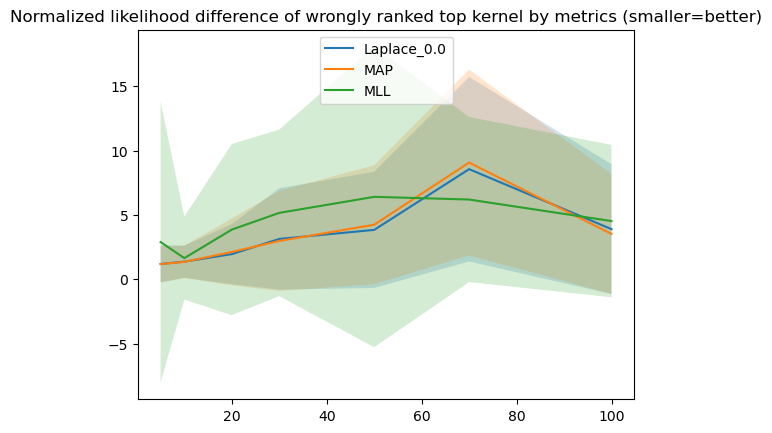

In [ ]:
# line plot with the means across varying dataset sizes

mean_dict = {metric:list() for metric in str_metrics}
std_dict = {metric:list() for metric in str_metrics}
target = total_mismatch_results
for dataset_size in target: 
    for metric in target[dataset_size]:
        mean_dict[metric].append(np.nanmean(target[dataset_size][metric]))
        std_dict[metric].append(np.nanstd(target[dataset_size][metric]))
        #np.std(total_tau_results[metric])
        #np.std(total_spearr_results[metric])


for metric in ["Laplace_0.0", "MAP", "MLL"]:#tau_mean_dict:
    plt.plot(dataset_sizes, mean_dict[metric],  label=metric)
    plt.fill_between(dataset_sizes, torch.Tensor(mean_dict[metric]) - torch.Tensor(std_dict[metric]), torch.Tensor(mean_dict[metric]) + torch.Tensor(std_dict[metric]), alpha=0.2)
plt.legend(loc=9)
plt.title("Normalized likelihood difference of wrongly ranked top kernel by metrics (smaller=better)")
#tikzplotlib.save("evaluation/correlation_likelihood_tau.tex")

## Distance from best kernel to best MCMC kernel in terms of ranking
Explanation: We check how far away the best kernel found by metric X in {Laplace, AIC, BIC, MLL, MAP} is to the best kernel found by MCMC (our baseline).

In [ ]:
# How far away from the first place is the first place in each metric
# Do this for each entry in the metric? Do this for the top-k entries?
ranking_results_dict = dict()
spearr_dict = dict()
total_ranking_results = {datasize:{metric:list() for metric in str_metrics} for datasize in dataset_sizes} 
for data_kernel in mcmc_ranking_dict:
    for dataset_size in dataset_sizes:
        ranking_results = {datasize:{metric:list() for metric in str_metrics} for datasize in dataset_sizes} 
        for run in mcmc_ranking_dict[data_kernel][dataset_size]:
            for metric in str_metrics:
                # Check the ranking of the metric to MCMC 
                MCMC_ranking_list = [entry[1] for entry in run["MC"]]
                metric_ranking_difference = [abs(i - MCMC_ranking_list.index(entry[1])) for i, entry in enumerate(run[metric])]
                
                ranking_results[dataset_size][metric].append(metric_ranking_difference)
                total_ranking_results[dataset_size][metric].append(metric_ranking_difference)

        ranking_results_dict[data_kernel] = ranking_results 

for dataset_size in total_ranking_results:
    print(dataset_size)
    for metric in total_ranking_results[dataset_size]:
        #statistic = [sum(run[:]) for run in total_ranking_results[dataset_size][metric]]
        statistic = [run[0] for run in total_ranking_results[dataset_size][metric]]
        print(f"{metric} - {np.mean(statistic)} \pm {np.std(statistic)}")

5
AIC - 2.7333333333333334 \pm 1.7035909785574184
BIC - 2.8133333333333335 \pm 1.6345709596778666
MLL - 2.433333333333333 \pm 1.8089284734953515
MAP - 2.566666666666667 \pm 1.8847339924302904
Laplace_0.0 - 2.6 \pm 1.8867962264113207
Laplace_-1.0 - 2.6133333333333333 \pm 1.8895737320593997
Laplace_BIC - 2.6133333333333333 \pm 1.8895737320593997
10
AIC - 2.513333333333333 \pm 1.5905414871112988
BIC - 2.4466666666666668 \pm 1.6063900176759345
MLL - 2.3933333333333335 \pm 1.8543522379047144
MAP - 2.8933333333333335 \pm 1.851653915347634
Laplace_0.0 - 2.9 \pm 1.8538248748645778
Laplace_-1.0 - 2.8466666666666667 \pm 1.8999532157982792
Laplace_BIC - 2.8266666666666667 \pm 1.9034938636331058
20
AIC - 3.506666666666667 \pm 1.4224235968546393
BIC - 3.566666666666667 \pm 1.387643886433243
MLL - 1.6666666666666667 \pm 1.7113996870657915
MAP - 1.86 \pm 1.829499020679341
Laplace_0.0 - 1.8733333333333333 \pm 1.8413642285605047
Laplace_-1.0 - 1.9333333333333333 \pm 1.8318175552045448
Laplace_BIC - 1.9

Text(0.5, 1.0, 'Difference in ranking top kernel by metrics (smaller=better)')

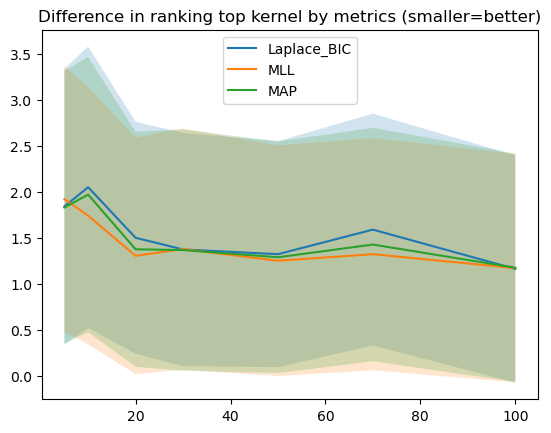

In [ ]:
# line plot with the means across varying dataset sizes

mean_dict = {metric:list() for metric in str_metrics}
std_dict = {metric:list() for metric in str_metrics}
target = total_ranking_results
for dataset_size in target: 
    for metric in target[dataset_size]:
        #mean_dict[metric].append(np.mean(target[dataset_size][metric]))
        #std_dict[metric].append(np.std(target[dataset_size][metric]))
        mean_dict[metric].append(np.mean([run for run in target[dataset_size][metric]]))
        std_dict[metric].append(np.std([run for run in target[dataset_size][metric]]))
        #np.std(total_tau_results[metric])
        #np.std(total_spearr_results[metric])


for metric in ["Laplace_BIC", "MLL", "MAP"]:#tau_mean_dict:
    plt.plot(dataset_sizes, mean_dict[metric],  label=metric)
    plt.fill_between(dataset_sizes, torch.Tensor(mean_dict[metric]) - torch.Tensor(std_dict[metric]), torch.Tensor(mean_dict[metric]) + torch.Tensor(std_dict[metric]), alpha=0.2)
plt.legend(loc=9)
plt.title("Difference in ranking top kernel by metrics (smaller=better)")
#tikzplotlib.save("evaluation/correlation_likelihood_tau.tex")

## Correlation of model evidence (MCMC likelihood) to metric
Explanation: This is supposed to give us the most information, as a high correlation to the behaviour of MCMC means the metric behaves the same!    
i.e. we could theoretically replace MCMC with that metric in case of perfect correlation.

In [ ]:
#scipy.stats.kendalltau([entry[1] for entry in result_dict["MAT32"][0]["MC"]], [entry[1] for entry in result_dict["MAT32"][0]["AIC"]])
#"Laplace_0.0", "Laplace_2.0", "Laplace_BIC"
#
kendall_tau_dict = dict()
spearr_dict = dict()
total_tau_results = {datasize:{metric:list() for metric in str_metrics} for datasize in dataset_sizes} 
total_spearr_results = {datasize:{metric:list() for metric in str_metrics} for datasize in dataset_sizes}
for data_kernel in mcmc_closeness_dict:
    for dataset_size in dataset_sizes:
        tau_results = {datasize:{metric:list() for metric in str_metrics} for datasize in dataset_sizes} 
        spearr_results = {datasize:{metric:list() for metric in str_metrics} for datasize in dataset_sizes}
        for run in mcmc_closeness_dict[data_kernel][dataset_size]:
            for metric in str_metrics:
                # Correlates the model evidence to the value of the respective metric
                tau = scipy.stats.kendalltau([entry[0] for entry in run["MC"]], [entry[0].detach().numpy() for entry in run[metric]])
                spearr = scipy.stats.spearmanr([entry[0] for entry in run["MC"]], [entry[0].detach().numpy() for entry in run[metric]])
                tau_results[dataset_size][metric].append(tau.statistic)
                total_tau_results[dataset_size][metric].append(tau.statistic)
                spearr_results[dataset_size][metric].append(spearr.statistic)
                total_spearr_results[dataset_size][metric].append(spearr.statistic)
        kendall_tau_dict[data_kernel] = tau_results 
        spearr_dict[data_kernel] = spearr_results 

for dataset_size in total_tau_results:
    print(dataset_size)
    for metric in total_tau_results[dataset_size]:
        #statistic = [sum(run[:]) for run in total_ranking_results[dataset_size][metric]]
        statistic = [run for run in total_tau_results[dataset_size][metric]]
        print(f"{metric} - {np.nanmean(statistic)} \pm {np.nanstd(statistic)}")

5
AIC - -0.060538040015147204 \pm 0.4102402350733399
BIC - -0.0658713733484805 \pm 0.4024102111604537
MLL - 0.012728765052581218 \pm 0.41128975754511843
MAP - 0.05244444444444443 \pm 0.3818540862814965
Laplace_0.0 - 0.04177777777777778 \pm 0.38347701011136326
Laplace_-1.0 - 0.033777777777777775 \pm 0.37678929501713043
Laplace_BIC - 0.03911111111111112 \pm 0.3724741436050575
10
AIC - -0.02777190007965416 \pm 0.3654225106737365
BIC - -0.021539325886377674 \pm 0.3676437446756192
MLL - 0.14185042669475828 \pm 0.35883276538929876
MAP - -0.01565995525727069 \pm 0.37221863482376205
Laplace_0.0 - -0.03534675615212528 \pm 0.404121720795584
Laplace_-1.0 - -0.06398210290827741 \pm 0.4070870453215842
Laplace_BIC - -0.08993288590604026 \pm 0.41557494019373414
20
AIC - -0.35963718820861673 \pm 0.4166277767341491
BIC - -0.3578231292517007 \pm 0.39803611869467503
MLL - 0.3687074829931972 \pm 0.4262942055163063
MAP - 0.3351473922902494 \pm 0.40644435232053633
Laplace_0.0 - 0.3469387755102041 \pm 0.3871

In [ ]:
# By choosing the top 3-4 metrics here I can select which ones I want to put in the line plot
import itertools
for metric in str_metrics:
    print(f"{metric} - {np.round(np.nanmean(list(itertools.chain.from_iterable([total_tau_results[dataset_size][metric] for dataset_size in total_tau_results]))), 4)} \pm {np.round(np.nanstd(list(itertools.chain.from_iterable([total_tau_results[dataset_size][metric] for dataset_size in total_tau_results]))), 4)}")
    #print(f"{metric} - {np.round(np.mean(list(itertools.chain.from_iterable([total_spearr_results[dataset_size][metric] for dataset_size in total_spearr_results]))), 4)} \pm {np.round(np.std(list(itertools.chain.from_iterable([total_spearr_results[dataset_size][metric] for dataset_size in total_spearr_results]))), 4)}")

AIC - -0.265 \pm 0.4307
BIC - -0.2577 \pm 0.4293
MLL - 0.2917 \pm 0.4313
MAP - 0.2549 \pm 0.4361
Laplace_0.0 - 0.2569 \pm 0.4374
Laplace_-1.0 - 0.2411 \pm 0.4385
Laplace_BIC - 0.2195 \pm 0.4338


Text(0.5, 1.0, 'Kendall Tau between model evidence of MCMC and other metrics')

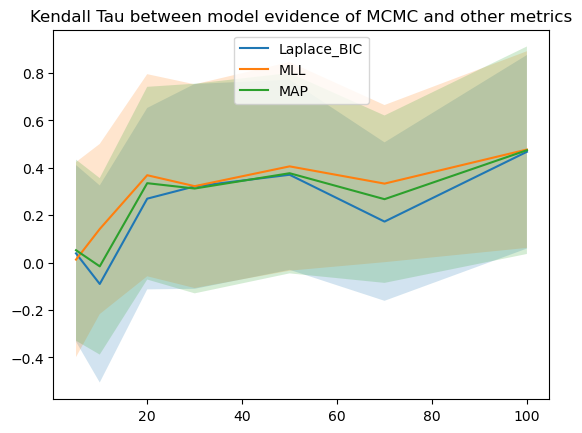

In [ ]:
# line plot with the means across varying dataset sizes

tau_mean_dict = {metric:list() for metric in str_metrics}
tau_std_dict = {metric:list() for metric in str_metrics}
spearr_mean_dict = {metric:list() for metric in str_metrics}
spearr_std_dict = {metric:list() for metric in str_metrics}
for dataset_size in total_tau_results: 
    for metric in total_tau_results[dataset_size]:
        tau_mean_dict[metric].append(np.nanmean(total_tau_results[dataset_size][metric]))
        tau_std_dict[metric].append(np.nanstd(total_tau_results[dataset_size][metric]))
        spearr_mean_dict[metric].append(np.mean(total_spearr_results[dataset_size][metric]))
        spearr_std_dict[metric].append(np.std(total_spearr_results[dataset_size][metric]))
        #np.std(total_tau_results[metric])
        #np.std(total_spearr_results[metric])


for metric in ["Laplace_BIC", "MLL", "MAP"]:#tau_mean_dict:
    #plt.plot(dataset_sizes, spearr_mean_dict[metric],  label=metric)
    #plt.fill_between(dataset_sizes, torch.Tensor(spearr_mean_dict[metric]) - torch.Tensor(spearr_std_dict[metric]), torch.Tensor(spearr_mean_dict[metric]) + torch.Tensor(spearr_std_dict[metric]), alpha=0.2)
    plt.plot(dataset_sizes, tau_mean_dict[metric],  label=metric)
    plt.fill_between(dataset_sizes, torch.Tensor(tau_mean_dict[metric]) - torch.Tensor(tau_std_dict[metric]), torch.Tensor(tau_mean_dict[metric]) + torch.Tensor(tau_std_dict[metric]), alpha=0.2)
plt.legend(loc=9)
plt.title("Kendall Tau between model evidence of MCMC and other metrics")
#tikzplotlib.save("evaluation/correlation_likelihood_tau.tex")

## Correlation of the rankings to MCMC
Explanation: If the rankings between MCMC and metric X correlate, that means they are ordered the same way, even if it is just by a small margin (a margin not correlating in the model evidence for example).

In [ ]:


kendall_ranking_tau_dict = dict()
ranking_spearr_dict = dict()
total_ranking_tau_results = {datasize:{metric:list() for metric in str_metrics} for datasize in dataset_sizes} 
total_ranking_spearr_results = {datasize:{metric:list() for metric in str_metrics} for datasize in dataset_sizes}
for data_kernel in mcmc_ranking_dict:
    for dataset_size in dataset_sizes:
        ranking_tau_results = {datasize:{metric:list() for metric in str_metrics} for datasize in dataset_sizes} 
        ranking_spearr_results = {datasize:{metric:list() for metric in str_metrics} for datasize in dataset_sizes}
        for run in mcmc_ranking_dict[data_kernel][dataset_size]:
            for metric in str_metrics:
                # Correlates the ranking of the model kernels to the one generated by MCMC
                ranking_tau = scipy.stats.kendalltau([entry[1] for entry in run["MC"]], [entry[1] for entry in run[metric]])
                ranking_spearr = scipy.stats.spearmanr([entry[1] for entry in run["MC"]], [entry[1] for entry in run[metric]])
                ranking_tau_results[dataset_size][metric].append(ranking_tau.statistic)
                total_ranking_tau_results[dataset_size][metric].append(ranking_tau.statistic)
                ranking_spearr_results[dataset_size][metric].append(ranking_spearr.statistic)
                total_ranking_spearr_results[dataset_size][metric].append(ranking_spearr.statistic)
        kendall_ranking_tau_dict[data_kernel] = ranking_tau_results 
        ranking_spearr_dict[data_kernel] = ranking_spearr_results 

for dataset_size in total_ranking_tau_results:
    print(dataset_size)
    for metric in total_ranking_tau_results[dataset_size]:
        #statistic = [sum(run[:]) for run in total_ranking_results[dataset_size][metric]]
        statistic = [run for run in total_ranking_tau_results[dataset_size][metric]]
        print(f"{metric} - {np.nanmean(statistic)} \pm {np.nanstd(statistic)}")


5
AIC - 0.03200000000000001 \pm 0.3741039665357449
BIC - 0.015999999999999997 \pm 0.36357728813065926
MLL - -0.003555555555555558 \pm 0.41389114093347046
MAP - 0.034666666666666665 \pm 0.37004264018563526
Laplace_0.0 - 0.10044444444444443 \pm 0.35047030130777906
Laplace_-1.0 - 0.08888888888888888 \pm 0.32126293988446575
Laplace_BIC - 0.07466666666666666 \pm 0.2962401428271027
10
AIC - 0.047111111111111104 \pm 0.3360376228201498
BIC - 0.059555555555555556 \pm 0.3393367532389697
MLL - 0.043555555555555556 \pm 0.37546902356162615
MAP - 0.01955555555555555 \pm 0.38278098692413826
Laplace_0.0 - 0.10666666666666667 \pm 0.393653353806319
Laplace_-1.0 - 0.07111111111111111 \pm 0.3962540649010648
Laplace_BIC - 0.10044444444444445 \pm 0.3669894875205791
20
AIC - -0.24088888888888887 \pm 0.4443413213696687
BIC - -0.2497777777777778 \pm 0.4184052026209125
MLL - 0.3671111111111111 \pm 0.4275509355259743
MAP - 0.3111111111111111 \pm 0.392950221457133
Laplace_0.0 - 0.31377777777777777 \pm 0.385326925

In [ ]:
import itertools
for metric in str_metrics:
    print(f"{metric} - {np.round(np.mean(list(itertools.chain.from_iterable([total_ranking_tau_results[dataset_size][metric] for dataset_size in total_ranking_tau_results]))), 4)} \pm {np.round(np.std(list(itertools.chain.from_iterable([total_ranking_tau_results[dataset_size][metric] for dataset_size in total_ranking_tau_results]))), 4)}")
    #print(f"{metric} - {np.round(np.mean(list(itertools.chain.from_iterable([total_spearr_results[dataset_size][metric] for dataset_size in total_spearr_results]))), 4)} \pm {np.round(np.std(list(itertools.chain.from_iterable([total_spearr_results[dataset_size][metric] for dataset_size in total_spearr_results]))), 4)}")

AIC - -0.1733 \pm 0.4425
BIC - -0.171 \pm 0.43
MLL - 0.2785 \pm 0.4415
MAP - 0.2627 \pm 0.4162
Laplace_0.0 - 0.2828 \pm 0.4028
Laplace_-1.0 - 0.2725 \pm 0.3964
Laplace_BIC - 0.2712 \pm 0.3693


In [ ]:

print(all_results[0]["results"]["attributes"])

{'eval_START': -5, 'eval_END': 5, 'eval_COUNT': 100, 'optimizer': 'PyGRANSO', 'train_iters': 100, 'LR': 0.1, 'BFGS': False, 'data_gen': 'LIN'}


In [ ]:
#print(all_results[0]["results"]["results"][0]["MC"]["SE"]["details"]["seed"])
#for i in range(7):
#    print(i)
#    for model_kernel in ["SE", "SE+SE", "MAT32"]:
#        #print(all_results[i]["results"]["results"][0]["Laplace"][model_kernel][-1.0]["loss"])
#        gen = all_results[i]["results"]["attributes"]["data_gen"]
#        count = all_results[i]["results"]["attributes"]["eval_COUNT"] 
#        MC = all_results[i]["results"]["results"][0]["MC"][model_kernel]["loss"]
#        other = all_results[i]["results"]["results"][0]["Laplace"][model_kernel]["BIC"]["loss"]
#        print(f"{gen} - {count} - {model_kernel} - {MC} - {other} - {abs(MC) - abs(other)}")

Text(0.5, 1.0, 'Kendall Tau between rankings of MCMC and other metrics')

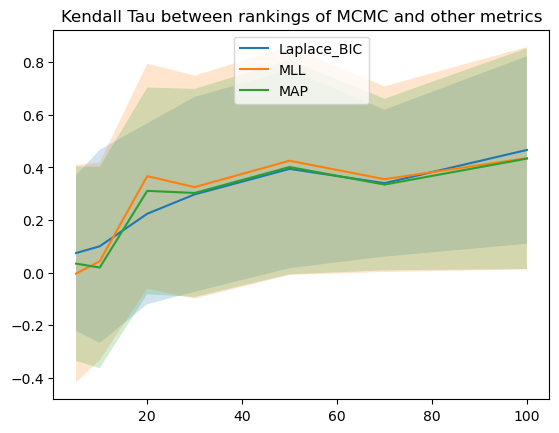

In [ ]:
# line plot with the means across varying dataset sizes

tau_mean_dict = {metric:list() for metric in str_metrics}
tau_std_dict = {metric:list() for metric in str_metrics}
spearr_mean_dict = {metric:list() for metric in str_metrics}
spearr_std_dict = {metric:list() for metric in str_metrics}
for dataset_size in total_ranking_tau_results: 
    for metric in total_ranking_tau_results[dataset_size]:
        tau_mean_dict[metric].append(np.mean(total_ranking_tau_results[dataset_size][metric]))
        tau_std_dict[metric].append(np.std(total_ranking_tau_results[dataset_size][metric]))
        spearr_mean_dict[metric].append(np.mean(total_ranking_spearr_results[dataset_size][metric]))
        spearr_std_dict[metric].append(np.std(total_ranking_spearr_results[dataset_size][metric]))
        #np.std(total_tau_results[metric])
        #np.std(total_spearr_results[metric])


for metric in ["Laplace_BIC", "MLL", "MAP"]:#tau_mean_dict:
    #plt.plot(dataset_sizes, spearr_mean_dict[metric],  label=metric)
    #plt.fill_between(dataset_sizes, torch.Tensor(spearr_mean_dict[metric]) - torch.Tensor(spearr_std_dict[metric]), torch.Tensor(spearr_mean_dict[metric]) + torch.Tensor(spearr_std_dict[metric]), alpha=0.2)
    plt.plot(dataset_sizes, tau_mean_dict[metric],  label=metric)
    plt.fill_between(dataset_sizes, torch.Tensor(tau_mean_dict[metric]) - torch.Tensor(tau_std_dict[metric]), torch.Tensor(tau_mean_dict[metric]) + torch.Tensor(tau_std_dict[metric]), alpha=0.2)
plt.legend(loc=9)
plt.title("Kendall Tau between rankings of MCMC and other metrics")
#tikzplotlib.save("evaluation/correlation_likelihood_tau.tex")

In [ ]:
print(" & " + " & ".join([metric for metric in tau_mean_dict]))
for i, dataset_size in enumerate(dataset_sizes):
    row_means = [np.round(tau_mean_dict[metric][i], 3) for metric in tau_mean_dict]
    row_stds = [np.round(tau_std_dict[metric][i], 3) for metric in tau_std_dict]
    max_pos = row_means.index(max(row_means))
    row_vals_str = [f"${row_mean} \\pm {row_std}$" for row_mean, row_std in zip(row_means, row_stds)]
    row_vals_str[max_pos] = f"$\\mathbf{{{row_vals_str[max_pos][1:-1]}}}$"
    print(f"Tau \@ {dataset_size} & " + f" & \t".join([str(val) for val in row_vals_str]) + "\\\\")



 & AIC & BIC & MLL & MAP & Laplace_0.0 & Laplace_-1.0 & Laplace_BIC
Tau \@ 5 & $0.032 \pm 0.374$ & 	$0.016 \pm 0.364$ & 	$-0.004 \pm 0.414$ & 	$0.035 \pm 0.37$ & 	$\mathbf{0.1 \pm 0.35}$ & 	$0.089 \pm 0.321$ & 	$0.075 \pm 0.296$\\
Tau \@ 10 & $0.047 \pm 0.336$ & 	$0.06 \pm 0.339$ & 	$0.044 \pm 0.375$ & 	$0.02 \pm 0.383$ & 	$\mathbf{0.107 \pm 0.394}$ & 	$0.071 \pm 0.396$ & 	$0.1 \pm 0.367$\\
Tau \@ 20 & $-0.241 \pm 0.444$ & 	$-0.25 \pm 0.418$ & 	$\mathbf{0.367 \pm 0.428}$ & 	$0.311 \pm 0.393$ & 	$0.314 \pm 0.385$ & 	$0.288 \pm 0.362$ & 	$0.224 \pm 0.344$\\
Tau \@ 30 & $-0.273 \pm 0.418$ & 	$-0.26 \pm 0.422$ & 	$\mathbf{0.325 \pm 0.424}$ & 	$0.303 \pm 0.396$ & 	$0.29 \pm 0.405$ & 	$0.299 \pm 0.388$ & 	$0.298 \pm 0.37$\\
Tau \@ 50 & $-0.313 \pm 0.461$ & 	$-0.3 \pm 0.426$ & 	$\mathbf{0.426 \pm 0.434}$ & 	$0.402 \pm 0.408$ & 	$0.395 \pm 0.422$ & 	$0.386 \pm 0.422$ & 	$0.395 \pm 0.377$\\
Tau \@ 70 & $-0.198 \pm 0.404$ & 	$-0.19 \pm 0.392$ & 	$\mathbf{0.356 \pm 0.353}$ & 	$0.335 \pm 0.326$ & 

Text(0.5, 1.0, 'Spearr')

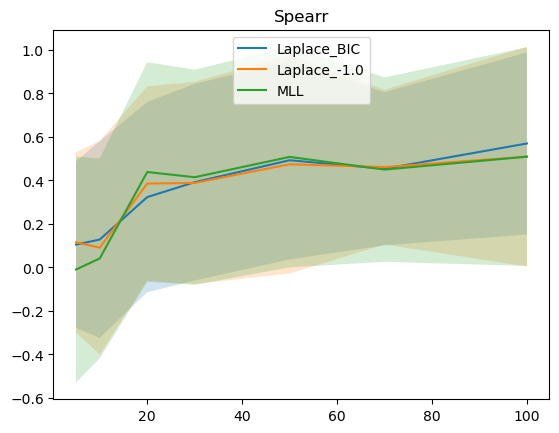

In [ ]:
for metric in ["Laplace_BIC", "Laplace_-1.0", "MLL"]:#tau_mean_dict:
    plt.plot(dataset_sizes, spearr_mean_dict[metric], label=metric)
    plt.fill_between(dataset_sizes, torch.Tensor(spearr_mean_dict[metric]) - torch.Tensor(spearr_std_dict[metric]), torch.Tensor(spearr_mean_dict[metric]) + torch.Tensor(spearr_std_dict[metric]), alpha=0.2)
plt.legend(loc=9)
plt.title("Spearr")

In [ ]:
import torch
import numpy as np
torch.tensor(np.inf, requires_grad=True) + torch.tensor(0)

tensor(inf, grad_fn=<AddBackward0>)

In [ ]:
for data_kernel in kendall_tau_dict:
    print(data_kernel)
    for metric in kendall_tau_dict[data_kernel]:
        print(f"TAU: \t{metric} - {np.mean(kendall_tau_dict[data_kernel][metric])} - {np.std(kendall_tau_dict[data_kernel][metric])}")
        print(f"R: \t{metric} - {np.mean(spearr_dict[data_kernel][metric])} - {np.std(spearr_dict[data_kernel][metric])}")
print("---------------")
for metric in total_tau_results:
    print(f"TAU: \t{metric} - {np.mean(total_tau_results[metric])} - {np.std(total_tau_results[metric])}")
    print(f"R: \t{metric} - {np.mean(total_spearr_results[metric])} - {np.std(total_spearr_results[metric])}")


SE


TypeError: unsupported operand type(s) for /: 'dict' and 'int'

# Kernel Search
Important note: HERE the AIC/BIC Values are the _actual_ AIC/BIC, no weird sign switching or something

## Load data

In [18]:
Lap_results = load_results("results", "Laplace")
AIC_results = load_results("results", "AIC")
BIC_results = load_results("results", "BIC")
MLL_results = load_results("results", "MLL")
MAP_results = load_results("results", "MAP")

In [19]:
all_results = {"Laplace" : Lap_results, "AIC": AIC_results, "BIC": BIC_results, "MLL": MLL_results, "MAP": MAP_results}

## Kernel recognitions

In [20]:
def shunting_yard(expression):
    output = []
    operators = []

    precedence = {'+': 1, '*': 2}

    tokens = expression.replace(' ', '')

    i = 0
    while i < len(tokens):
        if tokens[i].isalnum():
            # Handle variable names
            j = i + 1
            while j < len(tokens) and tokens[j].isalnum():
                j += 1

            output.append(tokens[i:j])
            i = j
        elif tokens[i] in '+*':
            # Handle operators
            while operators and operators[-1] in '+*' and precedence[operators[-1]] >= precedence[tokens[i]]:
                output.append(operators.pop())
            operators.append(tokens[i])
            i += 1
        elif tokens[i] == '(':
            # Handle left parentheses
            operators.append(tokens[i])
            i += 1
        elif tokens[i] == ')':
            # Handle right parentheses
            while operators and operators[-1] != '(':
                output.append(operators.pop())

            if operators and operators[-1] == '(':
                operators.pop()

            i += 1

    while operators:
        # Append remaining operators to output
        output.append(operators.pop())

    return output


class TreeNode:
    def __init__(self, value):
        self.value = value
        self.left = None
        self.right = None

def is_operator(token):
    return token in "+*"

def construct_tree(rpn_list):
    stack = []

    for token in rpn_list:
        if is_operator(token):
            node = TreeNode(token)
            node.right = stack.pop()
            node.left = stack.pop()
            stack.append(node)
        else:
            stack.append(TreeNode(token))

    return stack.pop()

def is_commutative_operator(token):
    return token in "+*"

def is_same_tree(tree1, tree2):
    if tree1 is None and tree2 is None:
        return True
    if tree1 is None or tree2 is None:
        return False

    if is_commutative_operator(tree1.value) and is_commutative_operator(tree2.value):
        return (is_same_tree(tree1.left, tree2.left) and is_same_tree(tree1.right, tree2.right)) or \
               (is_same_tree(tree1.left, tree2.right) and is_same_tree(tree1.right, tree2.left))

    return tree1.value == tree2.value and is_same_tree(tree1.left, tree2.left) and \
           is_same_tree(tree1.right, tree2.right)


# Test example
expression = '(((MAT32) * (MAT32)) + (PER))'
expression2 = '((PER) + ((MAT32) * (MAT32)))'
result = shunting_yard(expression)
result2 = shunting_yard(expression2)
result_tree = construct_tree(result)
result_tree2 = construct_tree(result2)
is_same_tree(result_tree, result_tree2)


True

In [17]:
import re
A = '(((c * MAT32) * (c * MAT32)) + (c * PER))'
B = '((c * SE) + (c * MAT32))'
re.findall(r'\([^()]*\)', A)
# Use this to get the most inner braces
#r'\([^()]*\)'
A = A.replace("c * ", "")
#re.findall(r'\([^()]*\)', A)
A

'(((MAT32) * (MAT32)) + (PER))'

In [18]:
res = re.findall('\((([^()]*|\(([^()]*|\([^()]*\))*\))*)\)', A)
#re.sub(whatever, replaceterm, kernel_string)
res


[('((MAT32) * (MAT32)) + (PER)', '', '')]

In [32]:
metrics = ["MLL", "AIC", "BIC", "MAP", "Laplace0.0", "Laplace-1.0", "LaplaceBIC"] 
recognition_dict = {data_num : {metric : list() for metric in metrics} for data_num in [5, 10, 20, 30, 40, 50, 100, 200]}
for key in ["AIC", "BIC", "MLL", "MAP", "Laplace"]: 
    current_results = all_results[key]
    for data in current_results:
        standard_laplace_failure_list = list()
        # I need 2 deep dict gets, one for data_num and one for parameter punishment (if its a laplace term)
        data_num = deep_dict_get(data, '/results/attributes/eval_COUNT')
        str_key = key
        if key in ["Laplace"]:
            threshold = deep_dict_get(data, '/results/attributes/parameter_punishment')
            str_key += str(threshold)
        nested_time = data["results"]["results"]["Nested details"]["Sample time"]
        KS_time = data["results"]["results"]["Kernel search time"]
        total_metric_time = sum([run["Total time"] for run in data["results"]["results"]["details"]])
        # Test likelihood 
        # Grab the "avg test mll" for each run
        test_mll = data["results"]["results"]["avg test mll"]
        # Model evidence
        # Grab the "MCMC approx" for each run
        #MCMC = data["results"]["results"]["MCMC approx"]
        # Grab the Nested Sampling approximation for each run
        logz = data["results"]["results"]["Nested approx"]
        #if abs(MCMC) > 500:
        #    MCMC = np.nan
        # Number of correctly found kernels
        found_kernel = data["results"]["results"]["final model"]
        data_kernel = data["results"]["attributes"]["Data_kernel"]

        found_kernel = found_kernel.replace("c * ", "")
        #runtime = data["results"]["results"]["runtime"]
        
        if str_key == "Laplace0.0":
            standard_laplace_failure_list = [torch.isnan(run["laplace without replacement"])for run in data["results"]["results"]["details"]] 

        result = shunting_yard(found_kernel)
        result2 = shunting_yard(data_kernel)
        result_tree = construct_tree(result)
        result_tree2 = construct_tree(result2)
        recognition_dict[data_num][str_key].append({"recognized": is_same_tree(result_tree, result_tree2), 
                                                    "Model evidence": logz, 
                                                    "test mll": test_mll*data_num, 
                                                    "found kernel": found_kernel, 
                                                    "data kernel": data_kernel,
                                                    "number of evaluated models": data["results"]["results"]["total count"],
                                                    "standard laplace failure": standard_laplace_failure_list,
                                                    "nested time":nested_time,
                                                    "kernel search time":KS_time,
                                                    "total metric time":total_metric_time,
                                                    })
        #if key == "Laplace":
        #    print(str_key)
        #    print(f"{found_kernel} - {data_kernel}")
        #if (key == "AIC" or key == "BIC") and data_num == 5:
        #    print(f"{key}: {found_kernel} - {data_kernel}")
        #    print(f"{data['results']['results']['details']}")
        #if key == "MAP":
        #    print(f"{found_kernel} - {data_kernel}")
        #if is_same_tree(result_tree, result_tree2) and key == "MAP":
        #    print("SUCCESS!")
        #    print(result)
        #    print(result2)
        #elif not is_same_tree(result_tree, result_tree2) and key == "MAP": 
        #    print("I will send you to Jesus!")
        #    print(result)
        #    print(result2)



# Runtimes

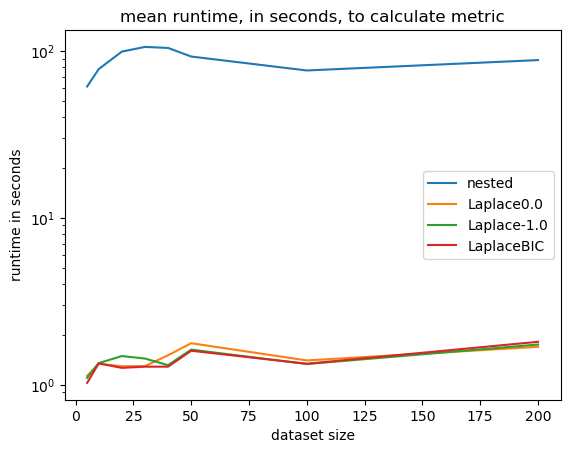

In [25]:
# We had 2 random restarts and 100 training iterations
# The recognition_dict has size: data_generating_kernel * Experiment_repetitions
# Which is currently 40
time_results = {data_num : {metric : {"metric": list(), "metric detailed":list()} for metric in metrics} for data_num in [5, 10, 20, 30, 40, 50, 100, 200]}

lap_0_evaluated_kernels_list = list()
for data_num in recognition_dict:
    time_results[data_num]["nested"] = list()  
    for metric in recognition_dict[data_num]:
        for run in recognition_dict[data_num][metric]:
            if metric in [ "Laplace0.0", "Laplace-1.0", "LaplaceBIC"]:
                time_results[data_num]["nested"].append(run["nested time"])
            num_evaluated_kernels = len(run["standard laplace failure"])
            approx_time_per_model = run["kernel search time"]/run["number of evaluated models"]
            time_results[data_num][metric]["metric"].append(approx_time_per_model)
            time_results[data_num][metric]["metric detailed"].append(np.average(run["total metric time"]))
            if metric == "Laplace0.0":
                lap_0_evaluated_kernels_list.append(num_evaluated_kernels)

# Print the avg nested time plus minus one standard deviation per dataset size
#for data_num in time_results:
#    print(data_num)
#    #print(f"{metric} - {np.average(time_results[data_num]['nested'])} \pm {np.std(time_results[data_num]['nested'])}")
#    for metric in time_results[data_num]:
#        if metric == "nested":
#            continue
#        #print(f"{metric} - {np.average(time_results[data_num][metric]['metric'])} \pm {np.std(time_results[data_num][metric]['metric'])}")
#        print(f"details: {metric} - {np.average(time_results[data_num][metric]['metric detailed'])} \pm {np.std(time_results[data_num][metric]['metric detailed'])}")
#
#

dataset_sizes = [5, 10, 20, 30, 40, 50, 100, 200]

#mean_dict.append(np.average(time_results[data_num]["nested"]))
#std_dict.append(np.std(time_results[data_num]["nested"]))
metrics_incl_nested = ["nested", "Laplace0.0", "Laplace-1.0", "LaplaceBIC"]# "MLL", "AIC", "BIC", "MAP", 
for metric in metrics_incl_nested:
    if metric == "nested":
        mean_dict = [np.average(time_results[data_num]["nested"]) for data_num in time_results]
        std_dict = [np.std(time_results[data_num]["nested"]) for data_num in time_results]
    else:
        mean_dict = [np.average(time_results[data_num][metric]["metric"]) for data_num in time_results]
        std_dict = [np.std(time_results[data_num][metric]["metric"]) for data_num in time_results]
    plt.plot(dataset_sizes, mean_dict,  label=metric)
    #plt.fill_between(dataset_sizes, torch.Tensor(mean_dict) - torch.Tensor(std_dict), torch.Tensor(mean_dict) + torch.Tensor(std_dict), alpha=0.2)
# make y axis log scale
plt.yscale('log')
plt.xlabel("dataset size")
plt.ylabel("runtime in seconds")
# draw red line at 0
# draw legend at top left location
plt.legend(loc="best")
plt.title("mean runtime, in seconds, to calculate metric")
tikzplotlib.save("evaluation/runtime_of_metrics.tex")

## Recognition Ratio

In [31]:
#recognition_dict = {data_num : {metric : list() for metric in metrics} for data_num in [5, 10, 20, 30]}
#for data_num in recognition_dict:
#    print("----")
#    for metric in recognition_dict[data_num]:
#        print(f"{data_num} - {metric} - {len(recognition_dict[data_num][metric])} - {sum([entry['recognized'] for entry in recognition_dict[data_num][metric]])}")

total_recognitions = {metric : list() for metric in metrics}
total_total_recognitions = {metric : list() for metric in metrics}
# In tabular form
print("num data &\t" + " &\t".join(metrics))
for data_num in recognition_dict:
    result_string = f"{data_num} & "
    for metric in metrics:
        result_string += f"{sum([entry['recognized'] for entry in recognition_dict[data_num][metric]])/len(recognition_dict[data_num][metric])*100:.1f} & "
        total_recognitions[metric].append(sum([entry['recognized'] for entry in recognition_dict[data_num][metric]]))
        total_total_recognitions[metric].append(len(recognition_dict[data_num][metric]))
    print(result_string)
avg_str = "avg.\ & "
for metric in metrics:
    avg_str += f"{sum(total_recognitions[metric])/sum(total_total_recognitions[metric])*100:.1f} & "
avg_str

num data &	MLL &	AIC &	BIC &	MAP &	Laplace0.0 &	Laplace-1.0 &	LaplaceBIC
5 & 2.5 & 42.5 & 45.0 & 0.0 & 42.5 & 42.5 & 45.0 & 
10 & 2.5 & 47.5 & 52.5 & 0.0 & 47.5 & 50.0 & 47.5 & 
20 & 0.0 & 65.0 & 60.0 & 0.0 & 55.0 & 55.0 & 55.0 & 
30 & 0.0 & 60.0 & 60.0 & 0.0 & 55.0 & 62.5 & 65.0 & 
40 & 0.0 & 60.0 & 60.0 & 0.0 & 62.5 & 67.5 & 65.0 & 
50 & 0.0 & 57.5 & 65.0 & 0.0 & 62.5 & 72.5 & 67.5 & 
100 & 0.0 & 60.0 & 70.0 & 0.0 & 67.5 & 75.0 & 72.5 & 
200 & 0.0 & 70.0 & 65.0 & 0.0 & 75.0 & 70.0 & 70.0 & 


'avg.\\ & 0.6 & 57.8 & 59.7 & 0.0 & 58.4 & 61.9 & 60.9 & '

## avg MCMC approximation and test likelihood

In [33]:
#recognition_dict = {data_num : {metric : list() for metric in metrics} for data_num in [5, 10, 20, 30]}
#for data_num in recognition_dict:
#    print("----")
#    for metric in recognition_dict[data_num]:
#        #mcmc_list = [entry['MCMC'] for entry in recognition_dict[data_num][metric] if abs(entry["MCMC"]) < 50 ]
#        mcmc_list = [entry['Model evidence'] for entry in recognition_dict[data_num][metric]]
#        test_mll_list = [entry['test mll'] for entry in recognition_dict[data_num][metric]]
#        print(f"{data_num} - {metric} - {np.nanmean(mcmc_list):.2f} \\pm {np.nanstd(mcmc_list):.2f} \t- {np.nanmean(test_mll_list):.2f} \\pm {np.nanstd(test_mll_list):.2f}")


# Model evidence - In tabular form
print("num data & " + " & ".join(metrics) + "\\\\")
for data_num in recognition_dict:
    result_string = f"{data_num}" 
    max_value = max([np.nanmean([entry['Model evidence'] for entry in recognition_dict[data_num][metric]]) for metric in metrics])
    for metric in metrics:
        mcmc_list = [entry['Model evidence'] for entry in recognition_dict[data_num][metric]]
        if np.nanmean(mcmc_list) >= max_value:
            result_string += f" & $\\mathbf{{{np.nanmean(mcmc_list):.2f} \\pm {np.nanstd(mcmc_list):.2f}}}$"
        else:
            result_string += f" & ${np.nanmean(mcmc_list):.2f} \\pm {np.nanstd(mcmc_list):.2f}$"
    result_string += "\\\\"
    print(result_string)



# Test likelihood - In tabular form
print("num data & " + " & ".join(metrics) + "\\\\")
for data_num in recognition_dict:
    result_string = f"{data_num}"

    max_value = max([np.nanmean([entry['test mll'] for entry in recognition_dict[data_num][metric]]) for metric in metrics])
    for metric in metrics:
        test_mll_list = [entry['test mll'] for entry in recognition_dict[data_num][metric]]
        if np.nanmean(test_mll_list) >= max_value:
            result_string += f" & $\\mathbf{{{np.nanmean(test_mll_list):.2f} \\pm {np.nanstd(test_mll_list):.2f}}}$"
        else:
            result_string += f" & ${np.nanmean(test_mll_list):.2f} \\pm {np.nanstd(test_mll_list):.2f}$"
    result_string += "\\\\"
    print(result_string)

num data & MLL & AIC & BIC & MAP & Laplace0.0 & Laplace-1.0 & LaplaceBIC\\
5 & $-9.00 \pm 2.56$ & $-5.38 \pm 3.71$ & $\mathbf{-5.28 \pm 3.85}$ & $-8.80 \pm 2.69$ & $-5.83 \pm 4.45$ & $-5.84 \pm 4.43$ & $-5.87 \pm 4.38$\\
10 & $-14.12 \pm 6.42$ & $-5.37 \pm 5.82$ & $-5.72 \pm 5.91$ & $-13.90 \pm 6.40$ & $\mathbf{-5.32 \pm 6.56}$ & $-5.46 \pm 6.56$ & $-5.63 \pm 6.71$\\
20 & $-23.50 \pm 15.63$ & $-2.54 \pm 8.94$ & $-3.54 \pm 8.52$ & $-23.92 \pm 15.90$ & $\mathbf{-1.84 \pm 8.91}$ & $-2.03 \pm 9.04$ & $-2.51 \pm 9.12$\\
30 & $-33.30 \pm 26.26$ & $\mathbf{5.25 \pm 11.29}$ & $4.53 \pm 11.45$ & $-33.32 \pm 25.28$ & $4.11 \pm 11.03$ & $3.84 \pm 11.22$ & $3.39 \pm 11.37$\\
40 & $-45.48 \pm 37.89$ & $12.33 \pm 12.01$ & $12.09 \pm 12.03$ & $-40.77 \pm 36.68$ & $\mathbf{13.32 \pm 11.56}$ & $13.09 \pm 11.63$ & $12.85 \pm 11.78$\\
50 & $-49.42 \pm 48.85$ & $21.14 \pm 14.19$ & $\mathbf{21.29 \pm 14.54}$ & $-48.06 \pm 47.07$ & $18.35 \pm 12.82$ & $18.02 \pm 12.97$ & $17.79 \pm 13.10$\\
100 & $-94.41 \p

In [64]:
total_calculated_kernels = 0
total_standard_laplace_failures = 0
for data_num in recognition_dict:
    for run in recognition_dict[data_num]["Laplace0.0"]:
        total_standard_laplace_failures += sum(run["standard laplace failure"])
        total_calculated_kernels += len(run["standard laplace failure"])
print(total_standard_laplace_failures/total_calculated_kernels*100)
print(total_calculated_kernels)
print(total_standard_laplace_failures)

tensor(40.3563)
4884
tensor(1971)


In [ ]:

[[entry['Model evidence'] for entry in recognition_dict[data_num][metric]]) for metric in ["Laplace0.0"] for data_num in recognition_dict]

In [38]:
metrics = ["MLL", "AIC", "BIC", "MAP", "Laplace0.0", "Laplace-1.0", "LaplaceBIC"] 
recognition_dict = {data_num : {metric : list() for metric in metrics} for data_num in [5, 10, 20, 30, 40, 50, 100, 200]}
results_by_num_and_data_kernel = {data_num : {data_kernel : {metric: list() for metric in metrics} for data_kernel in ["SE", "SE+SE", "LIN", "MAT32"]} for data_num in [5, 10, 20, 30, 40, 50, 100, 200]}
for key in ["AIC", "BIC", "MLL", "MAP", "Laplace"]: 
    current_results = all_results[key]
    for data in current_results:
        # I need 2 deep dict gets, one for data_num and one for parameter punishment (if its a laplace term)
        data_num = deep_dict_get(data, '/results/attributes/eval_COUNT')
        str_key = key
        if key in ["Laplace"]:
            threshold = deep_dict_get(data, '/results/attributes/parameter_punishment')
            str_key += str(threshold)
        data_kernel = data["results"]["attributes"]["Data_kernel"]
        results_by_num_and_data_kernel[data_num][data_kernel][str_key].append(data["results"]["results"])
 

## What to look for?
- How often does the standard laplace fail? I need to argue in favour of our replacement, if it never fails there's no point
- Construct the "difference" figure with AIC(?) as the SOTA
- How high is the error of each metric in estimating the corresponding model evidence?

In [39]:
MIN_EXP_NUM = 5
other_metrics = ["MLL", "BIC", "MAP", "Laplace0.0", "Laplace-1.0", "LaplaceBIC"] 
improvement_over_AIC = {data_num : {data_kernel : {metric: list() for metric in other_metrics} for data_kernel in ["SE", "SE+SE", "LIN", "MAT32"]} for data_num in [5, 10, 20, 30, 40, 50, 100, 200]}
for data_num in results_by_num_and_data_kernel:
    for generating_kernel in results_by_num_and_data_kernel[data_num]:
        # Everything except AIC
        for other_metric in other_metrics:
            for run in range(MIN_EXP_NUM):
                baseline = results_by_num_and_data_kernel[data_num][generating_kernel]["AIC"][run]["Nested approx"]
                contrahent = results_by_num_and_data_kernel[data_num][generating_kernel][other_metric][run]["Nested approx"]
                improvement_over_AIC[data_num][generating_kernel][other_metric].append(contrahent - baseline)
improvement_over_AIC

{5: {'SE': {'MLL': [-1.9994073732361208,
    -5.129665240849545,
    -4.198777184545528,
    -0.5786909467969359,
    -3.619276979003528],
   'BIC': [0.008145971880298752,
    -0.09569062731911071,
    0.01915785120991309,
    -0.004850603531885156,
    0.02382378863903245],
   'MAP': [-0.6026071014853098,
    -2.932179106647612,
    -3.736270587551032,
    -1.3302757603220812,
    -2.842770615306611],
   'Laplace0.0': [0.013272094357327013,
    -2.5443340310562936,
    -0.023156779650084225,
    0.006169880941089723,
    0.37894560537088573],
   'Laplace-1.0': [0.02337356276421243,
    -2.5500917777445746,
    0.0026689023767332287,
    0.006120854582168711,
    0.3820270718371379],
   'LaplaceBIC': [0.05468089162405043,
    -2.5321130687301716,
    -0.023002289850402313,
    -0.0038057660297763363,
    0.3552968112868218]},
  'SE+SE': {'MLL': [-1.4731109744931459,
    -4.1133843752522505,
    -4.424009923143583,
    0.16588487631604742,
    -2.9815362432292005],
   'BIC': [-0.0415050

In [40]:
rmse = lambda x : np.sqrt(np.mean(np.square(x)))
metrics = ["MLL", "MAP", "AIC", "BIC", "Laplace0.0", "Laplace-1.0", "LaplaceBIC"] 
model_evidence_estimate_difference = {data_num : {data_kernel : {metric: list() for metric in metrics} for data_kernel in ["SE", "SE+SE", "LIN", "MAT32"]} for data_num in [5, 10, 20, 30, 40, 50, 100, 200]}
for data_num in results_by_num_and_data_kernel:
    for generating_kernel in results_by_num_and_data_kernel[data_num]:
        for metric in metrics:
            for run in range(len(results_by_num_and_data_kernel[data_num][generating_kernel][metric])):
                baseline = results_by_num_and_data_kernel[data_num][generating_kernel][metric][run]["Nested approx"]
                approximation = results_by_num_and_data_kernel[data_num][generating_kernel][metric][run]["performance history"][-1]["performance"].detach().numpy()
                if metric in ["AIC", "BIC"]:
                    approximation = -0.5*approximation
                model_evidence_estimate_difference[data_num][generating_kernel][metric].append(rmse(approximation - baseline))

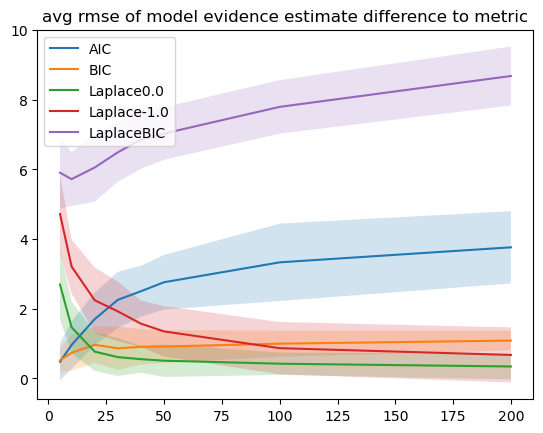

In [41]:
# Draw a boxplot for each metric
import matplotlib.pyplot as plt
other_metrics_w_o_mll_map = ["AIC", "BIC", "Laplace0.0", "Laplace-1.0", "LaplaceBIC"] 
relevant_metrics = metrics # other_metrics, other_metrics_w_o_mll_map
dataset_sizes = list()



# Do data prep
# make a dictionary for the mean values of each metric
mean_dict = {metric:list() for metric in relevant_metrics}
std_dict = {metric:list() for metric in relevant_metrics}
for data_num in model_evidence_estimate_difference:
    dataset_sizes.append(data_num)
    data = [[] for i in range(len(relevant_metrics))]
    for generating_kernel in model_evidence_estimate_difference[data_num]:
        for i, metric in enumerate(relevant_metrics):
            data[i].extend(model_evidence_estimate_difference[data_num][generating_kernel][metric])
    for i, metric in enumerate(relevant_metrics):
        mean_dict[metric].append(np.mean(data[i]))
        std_dict[metric].append(np.std(data[i]))



for metric in other_metrics_w_o_mll_map:#["LaplaceBIC", "Laplace-1.0", "BIC"]:#tau_mean_dict:
    plt.plot(dataset_sizes, mean_dict[metric],  label=metric)
    plt.fill_between(dataset_sizes, torch.Tensor(mean_dict[metric]) - torch.Tensor(std_dict[metric]), torch.Tensor(mean_dict[metric]) + torch.Tensor(std_dict[metric]), alpha=0.2)
# draw red line at 0
# draw legend at top left location
plt.legend(loc=2)
plt.title("avg rmse of model evidence estimate difference to metric")
tikzplotlib.save("evaluation/model_evidence_estimate_difference.tex")


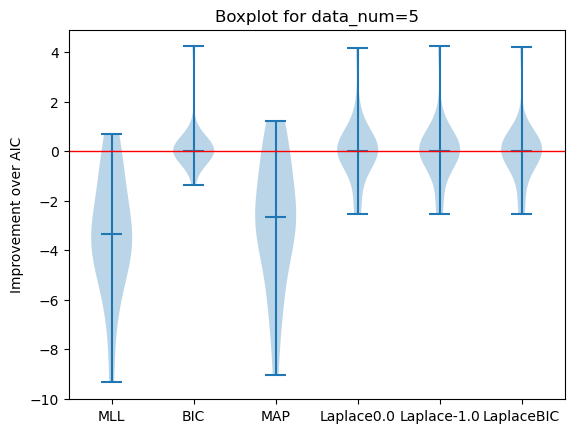

<Figure size 640x480 with 0 Axes>

In [42]:
# Draw a boxplot for each metric
import matplotlib.pyplot as plt
other_metrics_w_o_mll_map = ["BIC", "Laplace0.0", "Laplace-1.0", "LaplaceBIC"] 
relevant_metrics = other_metrics # other_metrics, other_metrics_w_o_mll_map
data_num = 5
# Get the data for the specified data_num and all generating_kernel
data = [[] for i in range(len(relevant_metrics))]
for generating_kernel in improvement_over_AIC[data_num]:
    for i, metric in enumerate(relevant_metrics):
        data[i].extend(improvement_over_AIC[data_num][generating_kernel][metric])

with open(f"evaluation/boxplot_data_num_{data_num}.dat", "w") as f:
    f.write("v \t set\n")
    for i, metric in enumerate(relevant_metrics):
        for value in data[i]:
            f.write(f"{value} \t {metric}\n")

# Create a figure and axis
fig, ax = plt.subplots()
# Draw the boxplot
#ax.boxplot(data)
ax.violinplot(data,
              showmeans=False,
              showmedians=True)
# Draw a horizontal line at 0
ax.axhline(y=0, color='r', linestyle='-', linewidth=1)
# Set the x-axis tick labels
#ax.set_xticklabels(relevant_metrics)
ax.set_xticks([y + 1 for y in range(len(data))],
                  labels=relevant_metrics)
# Set the y-axis label
ax.set_ylabel("Improvement over AIC")
# Set the title
ax.set_title(f"Boxplot for data_num={data_num}")
# Show the plot
plt.show()
fig.savefig(f"evaluation/boxplot_data_num_{data_num}.png", bbox_inches='tight')
tikzplotlib.save(f"evaluation/boxplot_data_num_{data_num}_w_o.tex")

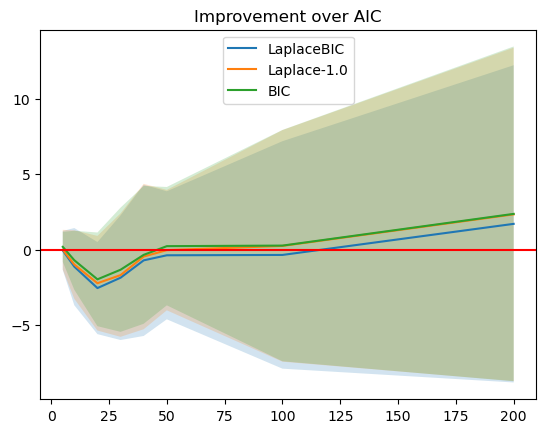

In [43]:
# Draw a boxplot for each metric
import matplotlib.pyplot as plt
other_metrics_w_o_mll_map = ["BIC", "Laplace0.0", "Laplace-1.0", "LaplaceBIC"] 
relevant_metrics = other_metrics # other_metrics, other_metrics_w_o_mll_map
dataset_sizes = list()


# Do data prep
# make a dictionary for the mean values of each metric
mean_dict = {metric:list() for metric in relevant_metrics}
std_dict = {metric:list() for metric in relevant_metrics}
for data_num in improvement_over_AIC:
    dataset_sizes.append(data_num)
    data = [[] for i in range(len(relevant_metrics))]
    for generating_kernel in improvement_over_AIC[data_num]:
        for i, metric in enumerate(relevant_metrics):
            data[i].extend(improvement_over_AIC[data_num][generating_kernel][metric])
    for i, metric in enumerate(relevant_metrics):
        mean_dict[metric].append(np.mean(data[i]))
        std_dict[metric].append(np.std(data[i]))



for metric in ["LaplaceBIC", "Laplace-1.0", "BIC"]:#tau_mean_dict:
    plt.plot(dataset_sizes, mean_dict[metric],  label=metric)
    plt.fill_between(dataset_sizes, torch.Tensor(mean_dict[metric]) - torch.Tensor(std_dict[metric]), torch.Tensor(mean_dict[metric]) + torch.Tensor(std_dict[metric]), alpha=0.2)
# draw red line at 0
plt.axhline(y=0, color='r', linestyle='-')
plt.legend(loc=9)
plt.title("Improvement over AIC")
tikzplotlib.save("evaluation/improvement_over_AIC.tex")

In [23]:

print(" & ".join(["MC", "AIC", "BIC", "Laplace"]))
print(" & ".join(list(all_the_results_tables[data_num].keys())))
for data_num in all_the_results_tables:
    result_line = f"\\multirow{{3}}{{*}}{{{data_num}}} & "
    for criterium in ["RR", "RR3", "runtime"]:
        result_line += f"{criterium}"
        for metric in all_the_results_tables[data_num]:
            if criterium in ["RR", "RR3"]:
                result_line += f" & {np.round(100*np.count_nonzero(all_the_results_tables[data_num][metric][criterium])/len(all_the_results_tables[data_num][metric][criterium]), 2)}"
            else:
                result_line += f" & {np.round(all_the_results_tables[data_num][metric][criterium], 2)}"
        result_line += "\\\\"
        print(result_line)
        result_line = " & "
    print("\\midrule")

MC & AIC & BIC & Laplace


NameError: name 'all_the_results_tables' is not defined

In [120]:
#all_the_results_tables = copy.deepcopy(results_table)
#all_the_results_tables_bak = copy.deepcopy(all_the_results_tables)
all_the_results_tables = {data_num: dict(list(all_the_results_tables[data_num].items()) + list(results_table[data_num].items())) for data_num in all_the_results_tables}

NameError: name 'all_the_results_tables' is not defined

In [ ]:
all_the_results_tables

In [ ]:

#all_the_confusion_results_bak = copy.deepcopy(all_the_confusion_results)

In [ ]:
#import copy
#all_the_confusion_results = copy.deepcopy(confusion_matrix_data)
#all_the_confusion_results = copy.deepcopy(all_the_confusion_results_bak)

In [ ]:
all_the_confusion_results = {data_num: dict(list(all_the_confusion_results[data_num].items()) + list(confusion_matrix_data[data_num].items())) for data_num in all_the_confusion_results}

In [ ]:
all_the_confusion_results

In [ ]:
fig, axs = plt.subplots(len(dataset_sizes), len(all_the_confusion_results[10]), sharey=True)
all_conf_matr_data = list()
#fig, axs = plt.subplots(1, 3, sharey=True)
for row, data_num in enumerate(dataset_sizes):#enumerate(confusion_matrix_data):
    all_conf_matr_data = list()
    for col, metric in enumerate(sorted(all_the_confusion_results[data_num])):
        all_conf_matr_data.extend([all_the_confusion_results[data_num][metric][data_kernel] for data_kernel in data_kernels])
    minmin = np.min(np.array(all_conf_matr_data).flatten())
    maxmax = np.max(np.array(all_conf_matr_data).flatten())
    for col, metric in enumerate(sorted(all_the_confusion_results[data_num])):
        #all_conf_matr_data.extend([all_the_confusion_results[data_num][metric][data_kernel] for data_kernel in data_kernels])
        im = axs[row, col].matshow([all_the_confusion_results[data_num][metric][data_kernel] for data_kernel in data_kernels], vmin=minmin, vmax=maxmax)
        #fig.colorbar(axs[row, col].matshow(single_conf_matr_data), cmap=plt.cm.GnBu)
        if row == 0:
            axs[row, col].set_xticks(range(len(model_kernels)))
            axs[row, col].set_xticklabels(model_kernels, rotation=90)
            axs[row, col].set_title(metric)
        else:
            axs[row, col].set_xticks([])
        axs[row, col].set_yticks(range(len(data_kernels)))
        if col == 0:
            axs[row, col].set_ylabel(data_num)
        axs[row, col].set_yticklabels(data_kernels)
    plt.colorbar(im)
        

#fig.colorbar(np.array(all_conf_matr_data))
#plt.colorbar(im)
fig.set_figwidth(30)
fig.set_figheight(15)
#plt.legend()

tikzplotlib.save("evaluation/confusion_matrix/allConfusionMatrix.tex")


In [ ]:
plt.close()

## statistics extraction
Extracting the test likelihood and model evidence for the plots in the next blocks

In [123]:
# Kernelsearch: Extract the ratio of recognitions to total kernels and the MCMC results for each metric
results_dict = {}
metrics = ["MLL", "AIC", "BIC", "MAP", "Laplace_prior0.0", "Laplace_prior-1.0", "Laplace_priorBIC"]
kernel_recognition_dict = {data_num : {metric : {"1" : 0, "2" : 0} for metric in metrics} for data_num in [5, 10, 20, 30, 40, 50, 70, 100, 150, 200]}
mcmc_performance_dict = {data_num : {metric : list() for metric in metrics} for data_num in [5, 10, 20, 30, 40, 50, 70, 100, 150, 200]}
test_likelihood_performance_dict = {data_num : {metric : list() for metric in metrics} for data_num in [5, 10, 20, 30, 40, 50, 70, 100, 150, 200]}
recognition_performance_dict = {data_num : {metric : list() for metric in metrics} for data_num in [5, 10, 20, 30, 40, 50, 70, 100, 150, 200]}
for data_num in [5, 10, 20, 30]:#, 40, 50, 70, 100, 150, 200]:
    print("======================")
    results_dict[data_num] = {}
    print(data_num)
    # Verify the recognition ratio of "PER", "MAT32", "PER*SE", "PER+SE", "MAT32*PER", "MAT32+PER"
    kernel_distributions = {}
    for key in ["AIC", "BIC", "MLL", "MAP", "Laplace"]:
        current_results = all_results[key]
        #pprint.pprint(result_tree)
        #total_runs = len(all_results[0])
        #print(all_results[0]['results']['attributes']['Data_kernel'])
        #winners = group_by(all_results, 'results/results/final model', value='(c * PER)')['results/results/final model = (c * PER)']
        data_kernels = [("SE", "(c * SE)"), ("RQ", "(c * RQ)"), ("PER", "(c * PER)"), ("MAT32", "(c * MAT32)"), ("PER*SE", "((c * PER) * (c * SE))"), ("PER+SE", "((c * PER) + (c * SE))"), ("MAT32*PER", "((c * MAT32) * (c * PER))"), ("MAT32+PER", "((c * MAT32) + (c * PER))"),("MAT32+SE", "((c * MAT32) + (c * SE))"),("MAT32*SE", "((c * MAT32) * (c * SE))")]
        data_500 = group_by_multiple(current_results, {'/results/attributes/eval_COUNT': data_num})
        #data_0_punish = group_by(all_results, '/results/attributes/parameter_punishment', 0.0)
 
        #kernel_distributions[key] = group_by(data_500[f"/results/attributes/eval_COUNT = {data_num}"], '/results/results/final model')
        if key in ["Laplace"]:
            data_500 = group_by(data_500[f"/results/attributes/eval_COUNT = {data_num}"], '/results/attributes/parameter_punishment')
            for punish_key in list(data_500.keys()):
                sum_recognized = 0
                sum_total = 0
                current_results = data_500[punish_key]
                mcmc_performance_dict[data_num][f"{key}{punish_key.split('=')[-1][1:]}"] = [run["results"]["results"]["MCMC approx"] for run in current_results]
                test_likelihood_performance_dict[data_num][f"{key}{punish_key.split('=')[-1][1:]}"] = [run["results"]["results"]["avg test mll"] for run in current_results]
                recognition_performance_dict[data_num][f"{key}{punish_key.split('=')[-1][1:]}"] = [
                    is_same_tree(
                        construct_tree(shunting_yard(run["results"]["results"]["final model"].replace("c * ", ""))),
                        construct_tree(shunting_yard(run["results"]["attributes"]["Data_kernel"]))) for run in current_results
                        ]
                
                winners = sum(recognition_performance_dict[data_num][f"{key}{punish_key.split('=')[-1][1:]}"])
                #if "+" in data_kernel or "*" in data_kernel:
                #    kernel_recognition_dict[data_num][f"{key}{punish_key.split('=')[-1][1:]}"]["2"] += recognized
                #else:
                #    kernel_recognition_dict[data_num][f"{key}{punish_key.split('=')[-1][1:]}"]["1"] += recognized
                #sum_recognized += recognized
                #sum_total += len(total_runs[f'/results/attributes/Data_kernel = {data_kernel}'])

                results_dict[data_num][f"{key}_{punish_key.split('=')[-1][1:]}"] = {}
                results_dict[data_num][f"{key}_{punish_key.split('=')[-1][1:]}"][f"Total"] = len(recognition_performance_dict[data_num][f"{key}{punish_key.split('=')[-1][1:]}"]) 
                results_dict[data_num][f"{key}_{punish_key.split('=')[-1][1:]}"][f"Recognized"] = winners 
                sum_total = len(recognition_performance_dict[data_num][f"{key}{punish_key.split('=')[-1][1:]}"])
                print(f"{key}{punish_key.split('=')[-1][1:]} - {winners}/{sum_total}")
        else:
            results_dict[data_num][key] = {}
            sum_recognized = 0
            sum_total = 0
            current_results = data_500[f"/results/attributes/eval_COUNT = {data_num}"]
            mcmc_performance_dict[data_num][f"{key}"] = [run["results"]["results"]["MCMC approx"] for run in current_results]
            test_likelihood_performance_dict[data_num][f"{key}"] = [run["results"]["results"]["avg test mll"] for run in current_results]
            recognition_performance_dict[data_num][f"{key}"] = [
                is_same_tree(
                    construct_tree(shunting_yard(run["results"]["results"]["final model"].replace("c * ", ""))),
                    construct_tree(shunting_yard(run["results"]["attributes"]["Data_kernel"]))) for run in current_results
                    ]
            
            winners = sum(recognition_performance_dict[data_num][f"{key}"])

            results_dict[data_num][key][f"Total"] = recognition_performance_dict[data_num][f"{key}"]
            results_dict[data_num][key][f"Recognized"] = winners 
            sum_total = len(recognition_performance_dict[data_num][f"{key}"])
            print(f"{key} - {winners}/{sum_total}")

with open("evaluation/temp_storage/mcmc_performance_dict.pickle", "wb") as f:
    pickle.dump(mcmc_performance_dict, f)

with open("evaluation/temp_storage/test_likelihood_performance_dict.pickle", "wb") as f:
    pickle.dump(test_likelihood_performance_dict, f)

with open("evaluation/temp_storage/recognition_performance_dict.pickle", "wb") as f:
    pickle.dump(recognition_performance_dict, f)

5
AIC - 77/200
BIC - 78/200
MLL - 1/200
MAP - 50/200
Laplace-1.0 - 85/200
Laplace0.0 - 84/200
LaplaceBIC - 86/200
10
AIC - 97/200
BIC - 95/200
MLL - 0/200
MAP - 50/200
Laplace-1.0 - 100/200
Laplace0.0 - 109/200
LaplaceBIC - 97/200
20
AIC - 115/200
BIC - 110/200
MLL - 0/200
MAP - 50/200
Laplace-1.0 - 111/200
Laplace0.0 - 119/200
LaplaceBIC - 119/200
30
AIC - 132/200
BIC - 130/200
MLL - 0/200
MAP - 50/200
Laplace-1.0 - 127/200
Laplace0.0 - 123/200
LaplaceBIC - 124/200


In [115]:
sum(recognition_performance_dict[5]["AIC"])

77

## recognition ratio

In [ ]:
# TODO write code for the recognition stuff

## test likelihood

ValueError: zero-size array to reduction operation minimum which has no identity

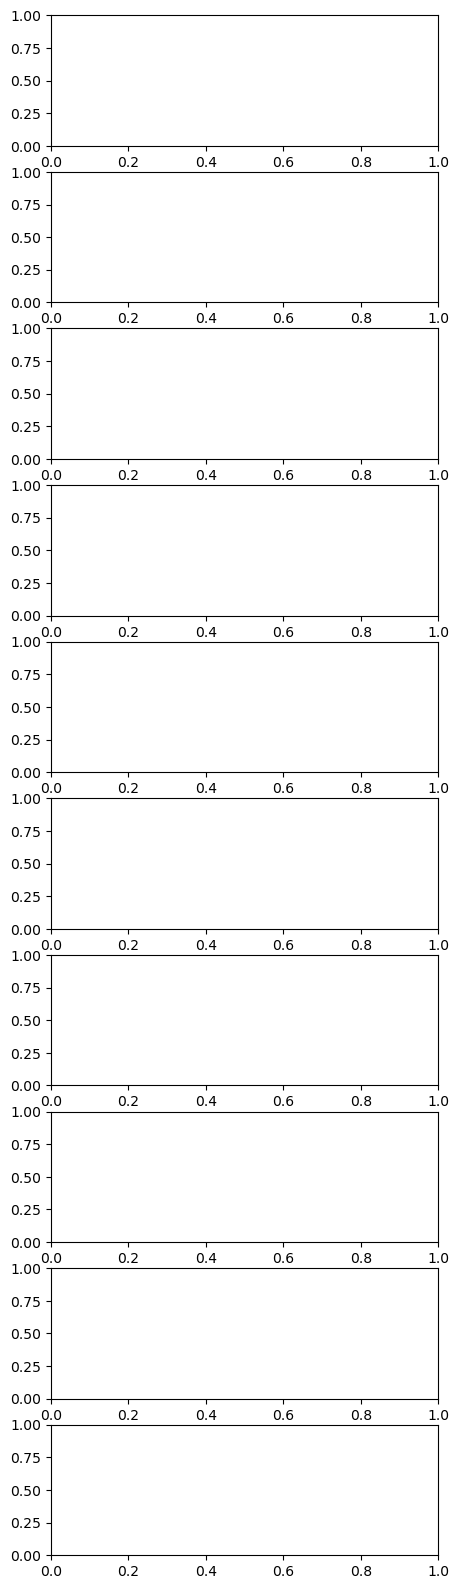

In [116]:
with open("evaluation/temp_storage/test_likelihood_performance_dict.pickle", "rb") as f:
    test_likelihood_performance_dict = pickle.load(f)

def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value

# Check the entry "MCMC approx" in the result dictionary and draw a violin plot for the found models (with different colors for different dataset sizes!)
fig, ax = plt.subplots(len(test_likelihood_performance_dict))
fig.set_figheight(20)
fig.set_figwidth(5)

colors = ["green", "blue"]
positions = [i for i in range(6)]
for i, data_num in enumerate(test_likelihood_performance_dict):
    violin_data = list()
    xlabels = list()
    for pos, metric in enumerate(test_likelihood_performance_dict[data_num]):
        # Create the list of vectors for the violinplot
        #violin_data.append([m for m in test_likelihood_performance_dict[data_num][metric] if not np.isnan(m)])
        violin_data.append(np.nan_to_num(test_likelihood_performance_dict[data_num][metric]))
        xlabels.append(metric)
    parts = ax[i].violinplot(
            violin_data, positions, showmeans=False, showmedians=False,
            showextrema=False)

    for pc in parts['bodies']:
        pc.set_facecolor('#D43F3A')
        pc.set_edgecolor('black')
        pc.set_alpha(1)
    quartile1, medians, quartile3 = np.nanpercentile(violin_data, [25, 50, 75], axis=1)
    means = np.nanmean(violin_data, axis=1)
    whiskers = np.array([
        adjacent_values(sorted_array, q1, q3)
        for sorted_array, q1, q3 in zip(violin_data, quartile1, quartile3)])
    whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]

    medians_ranking = [sorted(medians, reverse=True).index(x) if not np.isnan(x) else 5 for x in medians]
    medians_ranking = [m+1 for m in medians_ranking] 
    s = ax[i].scatter(positions, medians, marker='o', c=medians_ranking, cmap="viridis_r", s=40, zorder=3)
    #s = ax[i].scatter(positions, medians, marker='o', c=medians, cmap="viridis", s=40, zorder=3)
    ax[i].vlines(positions, quartile1, quartile3, color='k', linestyle='-', lw=5)
    ax[i].vlines(positions, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)

    ax[i].set_xticks(positions)
    ax[i].set_title(f"{data_num}")
    if i == len(test_likelihood_performance_dict)-1:
        ax[i].set_xticklabels(xlabels, rotation=60, fontsize=7)
    else:
        ax[i].set_xticklabels([])
    #ax.scatter(np.ones_like(test_likelihood_performance_dict[data_num][metric])*pos, mcmc_performance_dict[data_num][metric],  color=colors[i])
    cbar = fig.colorbar(s)
    cbar.ax.invert_yaxis()

fig.tight_layout()

## model evidence

ValueError: zero-size array to reduction operation minimum which has no identity

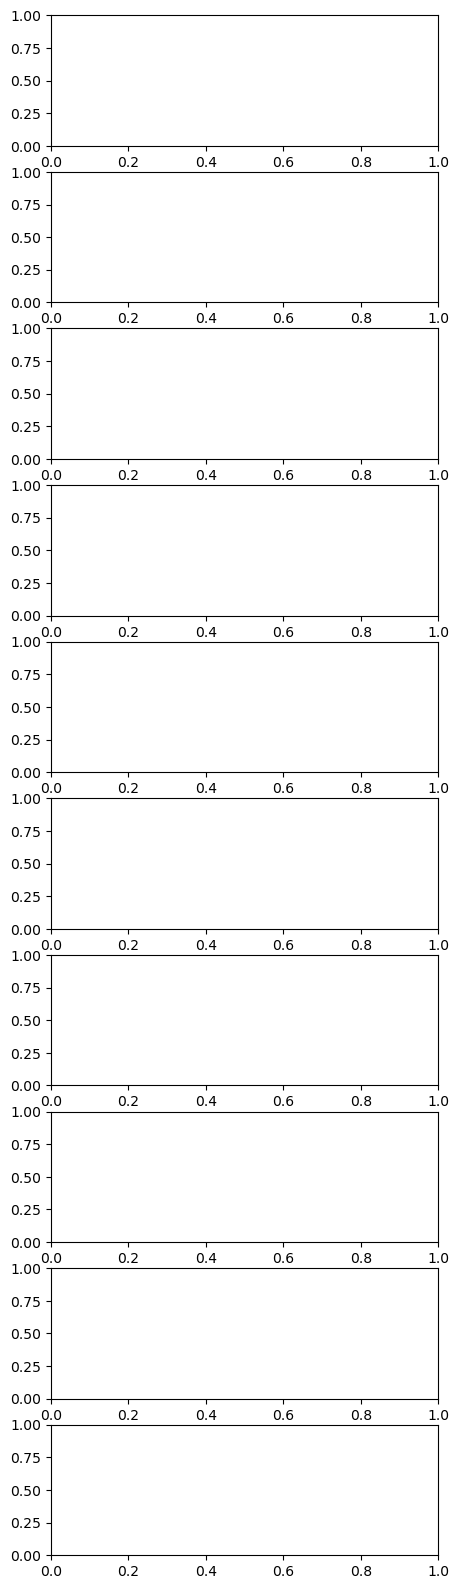

In [117]:
with open("evaluation/temp_storage/mcmc_performance_dict.pickle", "rb") as f:
    mcmc_performance_dict = pickle.load(f)

def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value

# Check the entry "MCMC approx" in the result dictionary and draw a violin plot for the found models (with different colors for different dataset sizes!)
fig, ax = plt.subplots(len(mcmc_performance_dict))
fig.set_figheight(20)
fig.set_figwidth(5)

colors = ["green", "blue"]
positions = [i for i in range(6)]
for i, data_num in enumerate(mcmc_performance_dict):
    violin_data = list()
    xlabels = list()
    for pos, metric in enumerate(mcmc_performance_dict[data_num]):
        # Create the list of vectors for the violinplot
        violin_data.append(mcmc_performance_dict[data_num][metric])
        xlabels.append(metric)
    parts = ax[i].violinplot(
            violin_data, positions, showmeans=False, showmedians=False,
            showextrema=False)

    for pc in parts['bodies']:
        pc.set_facecolor('#D43F3A')
        pc.set_edgecolor('black')
        pc.set_alpha(1)
    quartile1, medians, quartile3 = np.percentile(violin_data, [25, 50, 75], axis=1)
    means = np.mean(violin_data, axis=1)
    whiskers = np.array([
        adjacent_values(sorted_array, q1, q3)
        for sorted_array, q1, q3 in zip(violin_data, quartile1, quartile3)])
    whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]

    medians_ranking = [sorted(medians, reverse=True).index(x) if not np.isnan(x) else 5 for x in medians]
    medians_ranking = [m+1 for m in medians_ranking] 
    s = ax[i].scatter(positions, medians, marker='o', c=medians_ranking, cmap="viridis_r", s=40, zorder=3)
    #s = ax[i].scatter(positions, medians, marker='o', c=medians, cmap="viridis", s=40, zorder=3)
    ax[i].vlines(positions, quartile1, quartile3, color='k', linestyle='-', lw=5)
    ax[i].vlines(positions, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)

    ax[i].set_xticks(positions)
    ax[i].set_title(f"{data_num}")
    if i == len(mcmc_performance_dict)-1:
        ax[i].set_xticklabels(xlabels, rotation=60, fontsize=7)
    else:
        ax[i].set_xticklabels([])
    #ax.scatter(np.ones_like(mcmc_performance_dict[data_num][metric])*pos, mcmc_performance_dict[data_num][metric],  color=colors[i])
    cbar = fig.colorbar(s)
    cbar.ax.invert_yaxis()

fig.tight_layout()

In [118]:
#print([kernel for kernel in [ 'AIC', 'BIC', 'Laplace_2.0' 'Laplace_prior_0.0', 'Laplace_prior_BIC']])
print(" & ".join([k for k in results_dict[5]]))
for data_num in results_dict:
    #print(f"RR \\@ {data_num} & {' & '.join([str(100*results_dict[data_num][kernel]['Recognized']/results_dict[data_num][kernel]['Total']) for kernel in [  'AIC', 'BIC', 'Laplace_2.0' , 'Laplace_prior_0.0', 'Laplace_prior_BIC']])} \\\\")
    print(f"RR \\@ {data_num} & {' & '.join([str(100*results_dict[data_num][kernel]['Recognized']/results_dict[data_num][kernel]['Total']) for kernel in results_dict[data_num]])} \\\\")


AIC & BIC & MLL & Laplace_-1.0 & Laplace_0.0 & Laplace_BIC


TypeError: unsupported operand type(s) for /: 'int' and 'list'

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (5,) + inhomogeneous part.

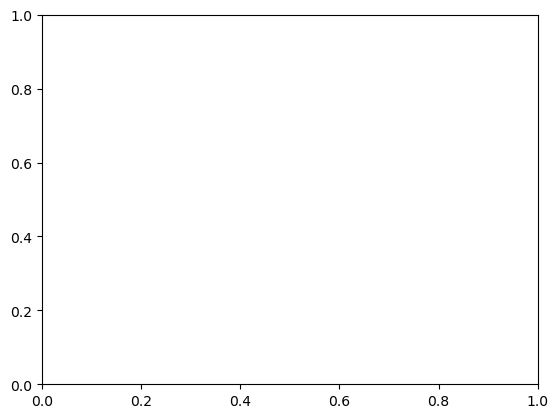

In [119]:
drawing_dataset = [list() for i in range(5)]
for i, data_num in enumerate(results_dict):
    keys = list(results_dict[data_num])
    for key in results_dict[data_num]:
        drawing_dataset[i].append(results_dict[data_num][key]["Recognized"])
plt.plot([10, 20, 50], drawing_dataset, marker='o', label=keys)
plt.ylabel("Recognized kernels")
plt.xlabel("Dataset size")
plt.legend(loc="upper right", bbox_to_anchor=(0.4, 0.0, 1, 1))
plt.savefig("evaluation/Recognized_kernels_per_datasets.png")

In [ ]:
len(all_results)

In [ ]:
for i, key in enumerate(kernel_distributions):
    fig, axs = plt.subplots(figsize=(15, 3))
    label_count = {}
    for kernel in sorted(kernel_distributions[key], key=len, reverse=False):
        kernel_name = kernel.split("=")[-1][1:]
        label_count[kernel_name] = len(kernel_distributions[key][kernel])
    axs.bar(range(len(label_count.keys())), label_count.values())
    axs.set_title(key)
    plt.xticks(range(len(label_count.keys())), label_count.keys(), rotation="vertical")


In [ ]:
#  The behaviour of the negative correction subtracted from the MAP resp. MLL values
key = "Laplace"
all_results = load_results('results', key)
#result_tree = generate_tree_structure(all_results[0]).descendants
all_results = group_by(all_results, '/results/attributes/parameter_punishment')
fig, axs = plt.subplots(1, 3, sharey=True)
for col, punish_level in enumerate(all_results):
    num_replaced_list = list()
    punish_term_list = list()
    param_num_list = [list() for i in range(0, 11, 1)]
    for result in all_results[punish_level]:
        details = deep_dict_get(result, "/results/results/details")
        # iterate over all kernels that were tried in the kernel search
        for tried_kernel in details:
            param_num_list[tried_kernel["num_replaced"]].append(
                tried_kernel["punish term"].item())
                #num_replaced_list.append(tried_kernel["num_replaced"])
                #punish_term_list.append(tried_kernel["punish term"][0][0])
    #axs[col].scatter(num_replaced_list, punish_term_list, marker=".")
    axs[col].boxplot(param_num_list, positions=range(0, 11, 1), showfliers=False)
    axs[col].plot([0,10], [0, 0], color="red", linewidth=0.5)
    axs[col].set_title(f"{punish_level.split('=')[-1]}")
    axs[col].set_xlabel("Replaced values")
    if col == 0:
        axs[col].set_ylabel("Punish term")
fig.set_figwidth(13)
fig.set_figheight(3)
tikzplotlib.save(f"evaluation/negative_correction_{key}_boxplot.tex")

In [ ]:
# The distribution of replaced parameters over the number of available parameters
key = "Laplace"
all_results = load_results('results', key)
#result_tree = generate_tree_structure(all_results[0]).descendants
all_results = group_by(all_results, '/results/attributes/parameter_punishment')
fig, axs = plt.subplots(1, 3, sharey=True)
for col, punish_level in enumerate(all_results):
    param_num_list = [list() for i in range(0, 11, 1)]
    for result in all_results[punish_level]:
        details = deep_dict_get(result, "/results/results/details")
        # iterate over all kernels that were tried in the kernel search
        for tried_kernel in details:
            param_num_list[len(tried_kernel["parameter list"])].append(
                tried_kernel["num_replaced"])
    #axs[col].scatter(num_replaced_list, punish_term_list, marker=".")
    axs[col].boxplot(param_num_list[3:], positions=range(3, 11, 1), showfliers=False)
    #axs[col].plot([0,max(num_replaced_list)], [0, 0], color="red")
    axs[col].set_title(f"{punish_level.split('=')[-1]}")
    axs[col].set_xlabel("Num. parameters")
    if col == 0:
        axs[col].set_ylabel("Num. replaced")
fig.set_figwidth(13)
fig.set_figheight(3)
tikzplotlib.save(f"evaluation/replaced_params_{key}.tex")

In [ ]:
# Boxplots over the number of parameters that each metric allows over the dataset sizes (i.e. kernel sizes)
kernel_distributions = {}
keys = ["MLL", "AIC", "BIC", "Laplace", "Laplace_prior"]
for data_num in [10, 50, 100, 250, 500]:
    print(data_num)
    num_param_list = [list() for i in range(len(keys))] 
    for i, key in enumerate(keys):
        print(key)
        all_results = load_results('results', key)
        datasize_filtered = group_by_multiple(all_results, {'/results/attributes/eval_COUNT': data_num})
        for result in datasize_filtered[list(datasize_filtered.keys())[0]]:
            parameters = deep_dict_get(result, "/results/results/parameters")
            num_param_list[i].append(len(parameters))
            # iterate over all kernels that were tried in the kernel search
    plt.violinplot(num_param_list)
    plt.title(f"Kernel sizes for {data_num} datapoints")
    plt.xlabel("Metric")
    plt.ylabel("Kernel size")
    plt.savefig(f"evaluation/kernel_sizes_{data_num}_violin.png")
    plt.close()


In [ ]:
# 
dataset_sizes = [10, 20, 30, 40, 50, 70, 100, 150, 200]
kernel_distributions = {}
#key = "Laplace_prior"
#all_results = load_results('results', key)
#result_tree = generate_tree_structure(all_results[0]).descendants
#avg_additional_punish = list()#[list() for i in range(0, 11, 1)]
#param_num_list = list()#[list() for i in range(0, 11, 1)] 
#punish_without_repl_list = [list() for i in range(0, 11, 1)] 
## Filter by the level of punishment, is this the same behaviour across all 3 levels?
#punish_val = "BIC"
#filtered_by_param_punish = group_by(all_results, '/results/attributes/parameter_punishment', punish_val)
#fig, axs = plt.subplots(1, len(dataset_sizes), sharey=True)
for key in ["Laplace", "Laplace_prior", "BIC", "AIC"]:
    all_results = load_results('results', key)
    if key in ["Laplace_prior"]:
    for punish_val in [0.0, 2.0, "BIC"]:
        print(punish_val)
        print(key)
        result_tree = generate_tree_structure(all_results[0]).descendants
        avg_additional_punish = list()#[list() for i in range(0, 11, 1)]
        param_num_list = list()#[list() for i in range(0, 11, 1)] 
        punish_without_repl_list = [list() for i in range(0, 11, 1)] 
        # Filter by the level of punishment, is this the same behaviour across all 3 levels?
        filtered_by_param_punish = group_by(all_results, '/results/attributes/parameter_punishment', punish_val)
        fig, axs = plt.subplots(1, len(dataset_sizes), sharey=True)
        for i, data_num in enumerate(dataset_sizes):
            print(data_num)
            group_by_size = group_by(filtered_by_param_punish[list(filtered_by_param_punish.keys())[0]], '/results/attributes/eval_COUNT', data_num)
            avg_additional_punish = list()#[list() for i in range(0, 11, 1)]
            param_num_list = list()#[list() for i in range(0, 11, 1)] 
            for result in group_by_size[list(group_by_size.keys())[0]]:
                details = deep_dict_get(result, "/results/results/details")
                # iterate over all kernels that were tried in the kernel search
                for tried_kernel in details:
                    if key == "Laplace":
                        new_val = (tried_kernel["punish without replacement"] - tried_kernel["punish term"])[0][0]#/tried_kernel["num_replaced"])
                    else:
                        new_val = (tried_kernel["punish without replacement"] - tried_kernel["punish term"])#/tried_kernel["num_replaced"])
                    if not new_val > 10000:
                        avg_additional_punish.append(new_val) 
                        param_num_list.append(len(tried_kernel["parameter list"]))
                    #punish_without_repl_list[len(tried_kernel["parameter list"])].append(tried_kernel["punish without replacement"])
                    #param_num_list[len(tried_kernel["parameter list"])].append(tried_kernel["num_replaced"])
            #plt.violinplot(param_num_list[3:], positions=range(3, 11))
            print(f"Total tried kernels: {len(avg_additional_punish)} - NaNs: {torch.count_nonzero(torch.Tensor([torch.isnan(p) for p in avg_additional_punish]))}")
            axs[i].scatter(param_num_list, avg_additional_punish)
            axs[i].plot([2.9,9.1], [0,0], color="red")
            #print(avg_additional_punish)
            #param_num_list

        fig.set_figwidth(20)
        fig.set_figheight(4)
            
        #plt.ylabel("oldHessian punish - newHessian punish")
        axs[0].set_ylabel("oldHessian punish - newHessian punish")
        axs[2].set_xlabel("num parameters")
        plt.savefig(f"evaluation/param_punish_difference_{key}_level_{punish_val}.png")
        plt.close()

In [ ]:
# Verify the recognition ratio of "PER", "MAT32", "PER*SE", "PER+SE", "MAT32*PER", "MAT32+PER"
keys = ["AIC", "MLL", "Laplace", "BIC"]
all_keys = keys + ["Laplace_prior"]
kernel_distributions = {}
avg_mlls = {key:list() for key in all_keys} 
avg_mlls_retrained = {key:list() for key in keys}
for key in keys:
    print(key)
    all_results = load_results('results', key, regex_scheme="0.pickle")
    result_tree = generate_tree_structure(all_results[0]).descendants
    data_num = 10
    data_500 = group_by(all_results, '/results/attributes/eval_COUNT', data_num)
    #data_0_punish = group_by(all_results, '/results/attributes/parameter_punishment', 0.0)

    for result in data_500[f"/results/attributes/eval_COUNT = {data_num}"]:
        avg_mll = deep_dict_get(result, "/results/results/avg test mll")
        if not np.isnan(avg_mll):
            if not np.isnan(torch.log(-avg_mll)):
                avg_mlls[key].append(avg_mll)
            else:
                print("THERE WAS SOMETHING POSITIVE!!!!")
print("Laplace_prior")
all_results = load_results('results', "Laplace_prior", regex_scheme="0.pickle")
result_tree = generate_tree_structure(all_results[0]).descendants
#data_500 = group_by(all_results, '/results/attributes/eval_COUNT', 500)
data_0_punish = group_by_multiple(all_results, {'/results/attributes/parameter_punishment': 0.0, '/results/attributes/eval_COUNT': data_num})

for result in data_0_punish[list(data_0_punish.keys())[0]]: #data_500["/results/attributes/eval_COUNT = 500"]:
    avg_mll = deep_dict_get(result, "/results/results/avg test mll")
    if not np.isnan(avg_mll):
        if not np.isnan(torch.log(-avg_mll)):
            avg_mlls["Laplace_prior"].append(avg_mll)
        else:
            print("THERE WAS SOMETHING POSITIVE!!!!")



        #avg_mll_retrained = deep_dict_get(result, "/results/results/avg test mll retrained")
        #if not np.isnan(avg_mll_retrained):
        #    avg_mlls_retrained[key].append(avg_mll_retrained)
plt.boxplot([avg_mlls[key] for key in all_keys], labels=[f"{key}-AVG" for key in all_keys], positions=range(len(all_keys)), showfliers=False)
#plt.violinplot([avg_mlls[key] for key in all_keys])#, labels=[f"{key}-AVG" for key in all_keys], positions=range(len(all_keys)))
#plt.boxplot([avg_mlls_retrained[key] for key in keys], labels=[f"{key}-AVG-R" for key in keys], positions=range(len(keys), 2*len(keys), 1))
plt.legend()





In [ ]:
punish_level = 2.0
for data_num in [10, 20,, 30, 40, 50]:#, 70, 100, 150, 200]:
    keys = ["AIC", "MLL", "BIC"]
    add_keys = ["Laplace_prior", "Laplace"]
    all_keys = keys + add_keys
    kernel_distributions = {}
    avg_mlls = {key:list() for key in all_keys} 
    avg_mlls_retrained = {key:list() for key in keys}
    for key in keys:
        print(key)
        all_results = load_results('results', key)#, regex_scheme="[0-9].pickle")
        result_tree = generate_tree_structure(all_results[0]).descendants
        #data_500 = group_by(all_results, '/results/attributes/Data_kernel','CO2')
        data_500 = group_by(all_results, '/results/attributes/eval_COUNT', data_num)
        #data_0_punish = group_by(all_results, '/results/attributes/parameter_punishment', 0.0)

        for result in data_500[f"/results/attributes/eval_COUNT = {data_num}"]:
            avg_mll = deep_dict_get(result, "/results/results/avg test mll")
            if not np.isnan(avg_mll):
                avg_mlls[key].append(avg_mll)
    for key in add_keys:
        print(key)
        all_results = load_results('results', key)#, regex_scheme="[0-9].pickle")
        result_tree = generate_tree_structure(all_results[0]).descendants
        data_0_punish = group_by_multiple(all_results, {'/results/attributes/parameter_punishment': punish_level, '/results/attributes/eval_COUNT': data_num})
        #data_0_punish = group_by(all_results, '/results/attributes/parameter_punishment', 0.0)

        for result in data_0_punish[list(data_0_punish.keys())[0]]:
            avg_mll = deep_dict_get(result, "/results/results/avg test mll")
            if not np.isnan(avg_mll):
                avg_mlls[key].append(avg_mll)
    #data_500 = group_by(all_results, '/results/attributes/eval_COUNT', 500)
            #avg_mll_retrained = deep_dict_get(result, "/results/results/avg test mll retrained")
            #if not np.isnan(avg_mll_retrained):
            #    avg_mlls_retrained[key].append(avg_mll_retrained)
    plt.boxplot([avg_mlls[key] for key in all_keys], labels=[f"{key}-AVG" for key in all_keys], positions=range(len(all_keys)), showfliers=False)
    #plt.violinplot([avg_mlls[key] for key in all_keys])#, labels=[f"{key}-AVG" for key in all_keys], positions=range(len(all_keys)))
    #plt.boxplot([avg_mlls_retrained[key] for key in keys], labels=[f"{key}-AVG-R" for key in keys], positions=range(len(keys), 2*len(keys), 1))
    plt.legend()
    plt.savefig(f"evaluation/{data_num}_log-likelihood_boxplot_{punish_level}-punish.png")
    plt.close()




# Kernel sizes across metrics

# Distribution of kernels per metric/data size

In [ ]:
metrics = ["Laplace0.0", "Laplace2.0", "LaplaceBIC",  "AIC", "BIC", "Laplace_prior0.0", "Laplace_prior2.0", "Laplace_priorBIC"]
keys = [ "AIC", "BIC"]
all_keys = keys + ["Laplace_prior", "Laplace"]

data_sizes = [10, 20, 30, 40, 50, 70, 100, 150, 200]

all_kernel_distributions = {data_num : {metric : {} for metric in 
                                       ["Laplace0.0", "Laplace2.0", "LaplaceBIC",  "AIC", "BIC", "Laplace_prior0.0", "Laplace_prior2.0", "Laplace_priorBIC"]}
                            for data_num in [10, 20, 30, 40, 50, 70, 100, 150, 200]}
for key in all_keys:
    print(key)
    all_results = load_results('results', key)#, regex_scheme=r_scheme)
    for data_num in data_sizes:
        data = group_by(all_results, '/results/attributes/eval_COUNT', data_num)
        data_keys = list(data.keys())
        if key in ["Laplace_prior", "Laplace"]:
            data = group_by(data[data_keys[0]], '/results/attributes/parameter_punishment') 
        for data_key in data:
            found_kernels_dict = {}
            for result in data[data_key]:
                final_model = deep_dict_get(result, 'results/results/final model')
                # Clean up kernel expression
                temp = final_model.replace("(", "")
                temp = temp.replace(")", "")
                temp = temp.replace(" ", "")
                temp = temp.replace("c*", "")
                # Sort the lists and sublists
                temp_list = [(sorted(s.split("*"))) for s in sorted(temp.split("+"))]
                final_model = "+".join(["*".join([s for s in sublist]) for sublist in temp_list])
                if not final_model in found_kernels_dict:
                    found_kernels_dict[final_model] = 1
                else:
                    found_kernels_dict[final_model] += 1
            # sanity check for number of entries
            if not sum([found_kernels_dict[k] for k in found_kernels_dict]) == 400:
                print(metric)
                print(data_num)
                print(sum([found_kernels_dict[k] for k in found_kernels_dict]))
            if key in ["Laplace_prior", "Laplace"]:
                all_kernel_distributions[data_num][f"{key}{data_key.split('=')[-1][1:]}"] = found_kernels_dict 
            else:
                all_kernel_distributions[data_num][f"{key}"] = found_kernels_dict
                


In [ ]:
all_kernel_distributions

In [ ]:
# Finding the kernel size in terms of kernel entries

simplified_kernel_distributions = {data_num : {metric : {1: 0, 2:0, 3:0} for metric in 
                                       ["Laplace0.0", "Laplace2.0", "LaplaceBIC",  "AIC", "BIC", "Laplace_prior0.0", "Laplace_prior2.0", "Laplace_priorBIC"]}
                            for data_num in [10, 20, 30, 40, 50, 70, 100, 150, 200]}
for data_num in all_kernel_distributions:
    for metric in all_kernel_distributions[data_num]:
        for found_kernel in all_kernel_distributions[data_num][metric]:
            # Get rid of all the constants
            #temp = found_kernel.replace("(", "")
            #temp = temp.replace(")", "")
            #temp = temp.replace(" ", "")
            #temp = temp.replace("c*", "")
            covar_string_list = [s.split("*") for s in found_kernel.split("+")]
            #temp_list = [(sorted([s.split("*")])) for s in sorted(found_kernel.split("+"))]
            #"+".join(["*".join([s for s in sublist]) for sublist in temp_list])
            simplified_kernel_distributions[data_num][metric][len(covar_string_list)] += all_kernel_distributions[data_num][metric][found_kernel]
        
simplified_kernel_distributions

In [ ]:
# Produce barplots for the summarized distributions
fig, axs = plt.subplots(len([10, 20, 30, 40, 50, 70, 100, 150, 200]),
                        len(simplified_kernel_distributions[10]), sharey=True)
for row, data_num in enumerate([10, 20, 30, 40, 50, 70, 100, 150, 200]):
    for col, metric in enumerate(simplified_kernel_distributions[data_num]):
        if row == 0:
            axs[row, col].set_title(metric)
        if col == 0:
            axs[row, col].set_ylabel(data_num)
        axs[row, col].bar(range(len(list(simplified_kernel_distributions[data_num][metric].keys()))),
                          [simplified_kernel_distributions[data_num][metric][k] for k in simplified_kernel_distributions[data_num][metric]],
                          tick_label=list(simplified_kernel_distributions[data_num][metric].keys()))
        #axs[row, col].tick_params('x', labelrotation=90)
        #plt.xticks(range(len(list(simplified_kernel_distributions[data_num][metric].keys()))), rotation=90)

fig.set_figwidth(15)
fig.set_figheight(10)
fig.tight_layout()
tikzplotlib.save("evaluation/kernel_distribution_summarized.tex")

In [ ]:
# Produce barplots for the detailed distributions
fig, axs = plt.subplots(4,#len(all_kernel_distributions),
                        len(all_kernel_distributions[10]), sharey=True)
#for row, data_num in enumerate(all_kernel_distributions):
#[10, 20, 30, 40, 50, 70, 100, 150, 200]
for row, data_num in enumerate([10, 20, 30, 40]):
    for col, metric in enumerate(all_kernel_distributions[data_num]):
        if row == 0:
            axs[row, col].set_title(metric)
        if col == 0:
            axs[row, col].set_ylabel(data_num)
        axs[row, col].bar(range(len(list(all_kernel_distributions[data_num][metric].keys()))),
                          [all_kernel_distributions[data_num][metric][k] for k in sorted(all_kernel_distributions[data_num][metric], key=len, reverse=False)],
                          tick_label=list(sorted(all_kernel_distributions[data_num][metric], key=len, reverse=False)))
        axs[row, col].tick_params('x', labelrotation=90)
        #plt.xticks(range(len(list(all_kernel_distributions[data_num][metric].keys()))), rotation=90)
fig.set_figwidth(30)
fig.set_figheight(15)
fig.tight_layout()

tikzplotlib.save("evaluation/kernel_distribution_small_datasizes.tex")

# Recognition ratio and avg. MLL plots/tables

In [ ]:
total_results = {data_num : {metric : {} for metric in 
                                       ["Laplace0.0", "Laplace2.0", "LaplaceBIC",  "AIC", "BIC", "Laplace_prior0.0", "Laplace_prior2.0", "Laplace_priorBIC"]}
                            for data_num in [5, 10, 20, 30, 40, 50, 70, 100, 150, 200]}

In [ ]:
#################
# Create table for evaluation
#################
keys = [ "AIC", "BIC"]# "MLL",
all_keys = keys + ["Laplace_prior", "Laplace"]
#all_keys = ["Laplace_prior"]

#datasizes = [10, 50, 100, 250, 500]
r_scheme = "[0-29].pickle"
datasizes = [5, 10, 20, 30, 40, 50, 70, 100, 150, 200]
metrics = ["AIC", "BIC", "Laplace_prior0.0", "Laplace_prior2.0", "Laplace_priorBIC", "Laplace0.0", "Laplace2.0", "LaplaceBIC"]
#param_punish = 0.0 
for key in all_keys:
    print(key)
    all_results = load_results('results', key)#, regex_scheme=r_scheme)
    result_tree = generate_tree_structure(all_results[0]).descendants
    kernel_distributions = {}
    for data_num in datasizes:
        avg_mlls = {key:list() for key in metrics} 
        if key in ["Laplace_prior", "Laplace"]:
            for param_punish in [0.0, 2.0, "BIC"]:
                data_500 = group_by_multiple(all_results, {'/results/attributes/parameter_punishment': param_punish, '/results/attributes/eval_COUNT': data_num})
                for result in data_500[list(data_500.keys())[0]]:
                    avg_mll = deep_dict_get(result, "/results/results/avg test mll")
                    if not np.isnan(avg_mll):
                        avg_mlls[f"{key}{param_punish}"].append(avg_mll)
                total_results[data_num][f"{key}{param_punish}"]["median"] = np.median(avg_mlls[f"{key}{param_punish}"])
                total_results[data_num][f"{key}{param_punish}"]["Q1"] = np.quantile(avg_mlls[f"{key}{param_punish}"], 0.33)
                total_results[data_num][f"{key}{param_punish}"]["Q3"] = np.quantile(avg_mlls[f"{key}{param_punish}"], 0.66)
        else:
            data_500 = group_by(all_results, '/results/attributes/eval_COUNT', data_num)
            for result in data_500[list(data_500.keys())[0]]:
                avg_mll = deep_dict_get(result, "/results/results/avg test mll")
                if not np.isnan(avg_mll):
                    avg_mlls[key].append(avg_mll)
            total_results[data_num][key]["median"] = np.median(avg_mlls[key])
            total_results[data_num][key]["Q1"] = np.quantile(avg_mlls[key], 0.33)
            total_results[data_num][key]["Q3"] = np.quantile(avg_mlls[key], 0.66)

AIC
BIC
Laplace_prior
Laplace


In [ ]:
total_results

{5: {'Laplace0.0': {},
  'Laplace2.0': {},
  'LaplaceBIC': {},
  'AIC': {},
  'BIC': {},
  'Laplace_prior0.0': {},
  'Laplace_prior2.0': {},
  'Laplace_priorBIC': {}},
 10: {'Laplace0.0': {'median': -0.5638637,
   'Q1': -1.2910209035873412,
   'Q3': 0.2136188599467278},
  'Laplace2.0': {'median': -0.3639787,
   'Q1': -1.3179158306121825,
   'Q3': 0.3059341037273408},
  'LaplaceBIC': {'median': -0.5293194,
   'Q1': -1.287655782699585,
   'Q3': 0.41870648562908225},
  'AIC': {'median': -0.13411152,
   'Q1': -1.3061450707912445,
   'Q3': 0.8159529554843916},
  'BIC': {'median': -0.7145959,
   'Q1': -1.465972625017166,
   'Q3': 0.39675737857818655},
  'Laplace_prior0.0': {'median': 0.14193709,
   'Q1': -1.0242484951019286,
   'Q3': 1.0462250161170963},
  'Laplace_prior2.0': {'median': -0.5900798,
   'Q1': -1.3935364830493926,
   'Q3': 0.3484532821178439},
  'Laplace_priorBIC': {'median': -0.6211333,
   'Q1': -1.3415072584152221,
   'Q3': 0.2916986995935451}},
 20: {'Laplace0.0': {'median':

AIC
BIC
Laplace_prior0.0
Laplace_prior2.0
Laplace_priorBIC
Laplace0.0
Laplace2.0
LaplaceBIC


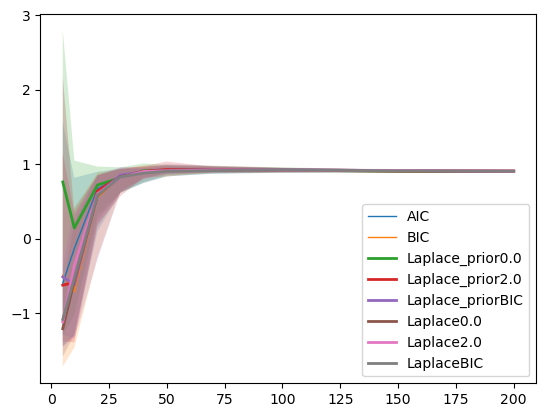

In [ ]:
# Matplotlib plot with fill between Q1 and Q3 and the median as the base values
metrics = ["Laplace"]#[ "AIC", "BIC", "Laplace_prior", "Laplace"]#"MLL",
metrics = [ "AIC", "BIC", "Laplace_prior", "Laplace"]#"MLL",
metrics = ["AIC", "BIC", "Laplace_prior0.0", "Laplace_prior2.0", "Laplace_priorBIC", "Laplace0.0", "Laplace2.0", "LaplaceBIC"]
#lines = ['', ' ', '--', '-.', '-', ':']
fig, ax = plt.subplots()
for metric in metrics:
    print(metric)
    medians = [total_results[k][metric]["median"] for k in total_results]
    lower = [total_results[k][metric]["Q1"] for k in total_results]
    upper = [total_results[k][metric]["Q3"] for k in total_results]
    x = [k for k in total_results]
    lw = 2.0 if any(text in metric for text in ["Laplace", "Laplace_prior"]) else 1.0
    ax.plot(x, medians, label=metric, linewidth=lw)
    #ax.errorbar(x, medians, yerr=[u-l for l, u in zip(lower, upper)])
    ax.fill_between(x, lower, upper, alpha=0.2)
plt.legend()
#plt.savefig("evaluation/mll_per_datapoint_full.png")
#tikzplotlib.save("evaluation/mll_per_datapoint_full.tex")

In [ ]:
print([kernel for kernel in ['AIC', 'BIC', 'Laplace_prior0.0', 'Laplace_prior2.0', 'Laplace_priorBIC', 'Laplace0.0', 'Laplace2.0', 'LaplaceBIC']])
for data_num in total_results:
    print(f"{data_num} & {' & '.join([str(total_results[data_num][kernel]['median']) for kernel in ['AIC', 'BIC', 'Laplace_prior0.0', 'Laplace_prior2.0', 'Laplace_priorBIC', 'Laplace0.0', 'Laplace2.0', 'LaplaceBIC']])} \\\\")

# CO2 dataset

In [ ]:

all_results = load_results('results', 'hardcoded_CO2')

In [ ]:
#all_results = load_results('results', 'hardcoded_CO2',  "results.pickle")#, regex_scheme=r_scheme)
loss_dict = {metric: list() for metric in ["AIC", "BIC", "MLL", "MAP", "Laplace_prior_0.0","Laplace_prior_-1.0","Laplace_prior_BIC", "MC", "test likelihood", "test likelihood(MAP)"]}
for result in all_results:
    for metric in ["AIC", "BIC", "MLL", "MAP", "Laplace_prior", "MC", "test likelihood", "test likelihood(MAP)"]:
        model_kernel = list(result["results"]["results"][0][metric].keys())[0]
        if metric == "Laplace_prior":
            for threshold in [0.0, -1.0, "BIC"]:
                loss = result["results"]["results"][0][metric][model_kernel][threshold]["loss"].detach().numpy()
                loss_dict[f"{metric}_{threshold}"].append((model_kernel, loss))
                print(f"{model_kernel}\t / {metric}_{threshold} : {loss}")
        elif "likelihood" in metric:
            loss = result["results"]["results"][0][metric][model_kernel].detach().numpy()
            loss_dict[f"{metric}"].append((model_kernel, loss))
        else:
            loss = result["results"]["results"][0][metric][model_kernel]["loss"].detach().numpy()
            loss_dict[f"{metric}"].append((model_kernel, loss))
            print(f"{model_kernel}\t / {metric} : {loss}")
        


(MAT32 + ((SE + PER) * SE))	 / AIC : 1417.4114990234375
(MAT32 + ((SE + PER) * SE))	 / BIC : 1391.181884765625
(MAT32 + ((SE + PER) * SE))	 / MLL : 714.7057495117188
(MAT32 + ((SE + PER) * SE))	 / MAP : 1179.126953125
(MAT32 + ((SE + PER) * SE))	 / Laplace_prior_0.0 : 1176.42066560058
(MAT32 + ((SE + PER) * SE))	 / Laplace_prior_-1.0 : 1171.42066560058
(MAT32 + ((SE + PER) * SE))	 / Laplace_prior_BIC : 1140.8970508423808
(MAT32 + ((SE + PER) * SE))	 / MC : -78277040.0
(MAT32 + (SE * PER))	 / AIC : 2406.53955078125
(MAT32 + (SE * PER))	 / BIC : 2384.681396484375
(MAT32 + (SE * PER))	 / MLL : 1208.269775390625
(MAT32 + (SE * PER))	 / MAP : 1183.0245361328125
(MAT32 + (SE * PER))	 / Laplace_prior_0.0 : 1180.3158740452675
(MAT32 + (SE * PER))	 / Laplace_prior_-1.0 : 1176.3158740452675
(MAT32 + (SE * PER))	 / Laplace_prior_BIC : 1151.1662842306298
(MAT32 + (SE * PER))	 / MC : -1894.55615234375
(MAT52 * (PER + (SE * PER)))	 / AIC : 1413.6202392578125
(MAT52 * (PER + (SE * PER)))	 / BIC : 138

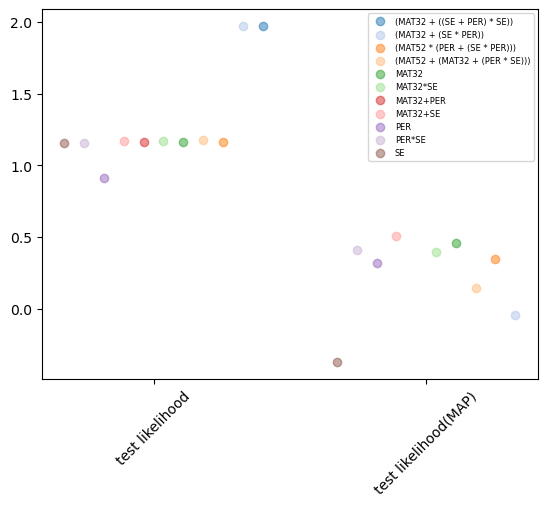

In [ ]:
#all_results = load_results('results', 'hardcoded_CO2',  "results.pickle")#, regex_scheme=r_scheme)
loss_dict = {metric: list() for metric in ["test likelihood", "test likelihood(MAP)"]}
for result in all_results:
    for metric in ["test likelihood", "test likelihood(MAP)"]:
        model_kernel = list(result["results"]["results"][0][metric].keys())[0]
        if metric == "Laplace_prior":
            for threshold in [0.0, -1.0, "BIC"]:
                loss = result["results"]["results"][0][metric][model_kernel][threshold]["loss"].detach().numpy()
                loss_dict[f"{metric}_{threshold}"].append((model_kernel, loss))
                print(f"{model_kernel}\t / {metric}_{threshold} : {loss}")
        elif "likelihood" in metric:
            loss = result["results"]["results"][0][metric][model_kernel].detach().numpy()
            loss_dict[f"{metric}"].append((model_kernel, loss))
        else:
            loss = result["results"]["results"][0][metric][model_kernel]["loss"].detach().numpy()
            loss_dict[f"{metric}"].append((model_kernel, loss))
            print(f"{model_kernel}\t / {metric} : {loss}")
import matplotlib.colors as cm
colors = [cm.to_hex(plt.cm.tab20(i)) for i in range(11)]
for x, metric in enumerate(loss_dict):
    for color, model_kernel in enumerate(loss_dict[metric]):
        kernel = model_kernel[0]
        loss = model_kernel[1]
        if loss > -2000:
            plt.scatter(x - color*(0.8/len(loss_dict[metric]))+0.4, loss, c=colors[color], alpha=0.5)
plt.xticks(ticks = [i for i in range(len(loss_dict))], labels=[metric for metric in loss_dict], rotation=45)
plt.legend([model_kernel[0] for model_kernel in loss_dict["test likelihood"]], fontsize=6)
#       


In [ ]:
loss_dict

{'test likelihood': [('(MAT32 + ((SE + PER) * SE))',
   array(1.9725587, dtype=float32)),
  ('(MAT32 + (SE * PER))', array(1.9707274, dtype=float32)),
  ('(MAT52 * (PER + (SE * PER)))', array(1.1659371, dtype=float32)),
  ('(MAT52 + (MAT32 + (PER * SE)))', array(1.1760887, dtype=float32)),
  ('MAT32', array(1.1610206, dtype=float32)),
  ('MAT32*SE', array(1.1673608, dtype=float32)),
  ('MAT32+PER', array(1.1601994, dtype=float32)),
  ('MAT32+SE', array(1.1710945, dtype=float32)),
  ('PER', array(0.9145737, dtype=float32)),
  ('PER*SE', array(1.1592531, dtype=float32)),
  ('SE', array(1.1559045, dtype=float32))],
 'test likelihood(MAP)': [('(MAT32 + ((SE + PER) * SE))',
   array(-46686.535, dtype=float32)),
  ('(MAT32 + (SE * PER))', array(-0.04333558, dtype=float32)),
  ('(MAT52 * (PER + (SE * PER)))', array(0.3454754, dtype=float32)),
  ('(MAT52 + (MAT32 + (PER * SE)))', array(0.14809191, dtype=float32)),
  ('MAT32', array(0.4616004, dtype=float32)),
  ('MAT32*SE', array(0.3975988, dt

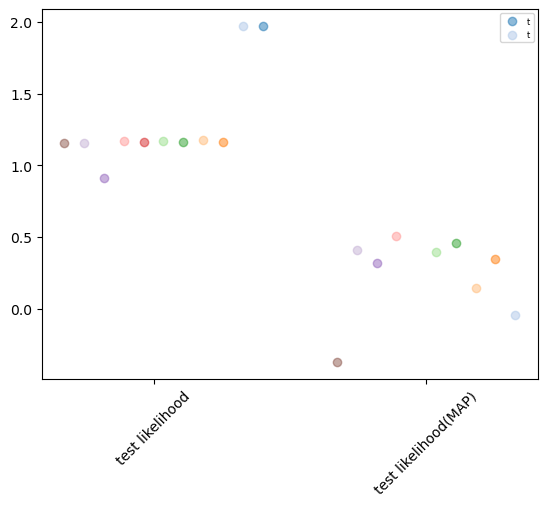

In [ ]:
import matplotlib.colors as cm
colors = [cm.to_hex(plt.cm.tab20(i)) for i in range(11)]
for x, metric in enumerate(loss_dict):
    for color, model_kernel in enumerate(loss_dict[metric]):
        kernel = model_kernel[0]
        loss = model_kernel[1]
        if loss > -2000:
            plt.scatter(x - color*(0.8/len(loss_dict[metric]))+0.4, loss, c=colors[color], alpha=0.5)
plt.xticks(ticks = [i for i in range(len(loss_dict))], labels=[metric for metric in loss_dict], rotation=45)
plt.legend([model_kernel[0] for model_kernel in loss_dict], fontsize=6)
#tikzplotlib.save("evaluation/CO2_likelihood_approximations.tex")

In [ ]:
loss_dict
for metric in loss_dict:
    #mc_list = [val[0] for val in sorted(loss_dict["MC"], key=lambda x:x[1], reverse=True)]
    #other_list = [val[0] for val in sorted(loss_dict[metric], key=lambda x:x[1], reverse=True)]
    #print(f"{metric}: {sorted(loss_dict[metric], key=lambda x:x[1], reverse=True)[0]}")
    mc_list = [val[1] for val in loss_dict["MC"]]
    other_list = [val[1] for val in loss_dict[metric]]
    print(f"{metric} & {np.round(scipy.stats.kendalltau(mc_list, other_list).statistic, 3)}")

KeyError: 'MC'

# LODE experiments

In [ ]:
#naming_schema = ["Metric", "Kernel_search", "train_data_ratio", "Data_kernel", "weights", "Variance_list", "eval_START", "eval_END", "eval_COUNT", "optimizer", "train_iterations", "LR", "Noise", "Data_scaling", "BFGS"]
all_results = load_results('results', "LODE", regex_scheme="results.pickle")
#
#postfix = ""
#result_tree = generate_tree_structure(all_results[0]).descendants


# What do I want to know?
# 1.) Does each metric recognize the correct kernels?
# 1.1.) If not: Why?
# 2.) Is the order I was talking about true?
# 2.1.) i.e. MLL > Laplace/AIC >=? MCMC
# 3.) Are models with redundant parameters more punished than others? Especially the 2SIN vs 3SIN case
# 4.) Make a ranking sheet per dataset where the models are compared _within_ a metric to see if there are similarities visible or something
#  
metrics = ["AIC", "BIC", "MLL", "MAP", {"Laplace": [0.0, 2.0, "BIC"]}, {"Laplace_prior": [0.0, 2.0, "BIC"]}]
dataset_sizes = [5, 10, 20, 30, 50, 70, 100, 150, 200] 
str_metrics = ["AIC", "BIC", "MLL", "MAP", "Laplace_0.0", "Laplace_2.0", "Laplace_BIC", "Laplace_prior_0.0", "Laplace_prior_2.0", "Laplace_prior_BIC"]

LODE_results = {dataset_size:{metric:{} for metric in str_metrics} for dataset_size in dataset_sizes}
# Iterate over all datasets
for main_dict in all_results:
    dataset_size = main_dict["results"]["attributes"]["eval_COUNT"]
    for run in main_dict["results"]["results"]:
        for metric in run:
            for model_type in run[metric]:
                if metric in ["Laplace", "Laplace_prior"]:
                    for threshold in run[metric][model_type]:
                        LODE_results[dataset_size][f"{metric}_{threshold}"][model_type] = run[metric][model_type][threshold]["loss"]
                else:
                        LODE_results[dataset_size][f"{metric}"][model_type] = run[metric][model_type]["loss"]



In [ ]:
LODE_results

{5: {'AIC': {'ideal LODE-GP': tensor(-10.2937, requires_grad=True),
   'overparameterized LODE-GP': tensor(-12.2936, requires_grad=True)},
  'BIC': {'ideal LODE-GP': tensor(-9.1220, requires_grad=True),
   'overparameterized LODE-GP': tensor(-10.7313, requires_grad=True)},
  'MLL': {'ideal LODE-GP': tensor(-2.1468, requires_grad=True),
   'overparameterized LODE-GP': tensor(-2.1468, requires_grad=True)},
  'MAP': {'ideal LODE-GP': tensor(-19.5598, requires_grad=True),
   'overparameterized LODE-GP': tensor(-23.8278, requires_grad=True)},
  'Laplace_0.0': {'ideal LODE-GP': tensor([[-11.8349]], dtype=torch.float64, requires_grad=True),
   'overparameterized LODE-GP': tensor([[-13.6089]], dtype=torch.float64, requires_grad=True)},
  'Laplace_2.0': {'ideal LODE-GP': tensor([[-11.9915]], dtype=torch.float64, requires_grad=True),
   'overparameterized LODE-GP': tensor([[-14.2745]], dtype=torch.float64, requires_grad=True)},
  'Laplace_BIC': {'ideal LODE-GP': tensor([[-12.2629]], dtype=torch.

In [ ]:
for datasize in LODE_results:
    print(datasize)
    for metric in LODE_results[datasize]:
        print(metric)
        print(f"{sorted(LODE_results[datasize][metric], key=lambda k: LODE_results[datasize][metric][k], reverse=True)}")


5
AIC
['ideal LODE-GP', 'overparameterized LODE-GP']
BIC
['ideal LODE-GP', 'overparameterized LODE-GP']
MLL
['overparameterized LODE-GP', 'ideal LODE-GP']
MAP
['ideal LODE-GP', 'overparameterized LODE-GP']
Laplace_0.0
['ideal LODE-GP', 'overparameterized LODE-GP']
Laplace_2.0
['ideal LODE-GP', 'overparameterized LODE-GP']
Laplace_BIC
['ideal LODE-GP', 'overparameterized LODE-GP']
Laplace_prior_0.0
['ideal LODE-GP', 'overparameterized LODE-GP']
Laplace_prior_2.0
['ideal LODE-GP', 'overparameterized LODE-GP']
Laplace_prior_BIC
['ideal LODE-GP', 'overparameterized LODE-GP']
10
AIC
['ideal LODE-GP', 'overparameterized LODE-GP']
BIC
['ideal LODE-GP', 'overparameterized LODE-GP']
MLL
['ideal LODE-GP', 'overparameterized LODE-GP']
MAP
['ideal LODE-GP', 'overparameterized LODE-GP']
Laplace_0.0
['overparameterized LODE-GP', 'ideal LODE-GP']
Laplace_2.0
['ideal LODE-GP', 'overparameterized LODE-GP']
Laplace_BIC
['ideal LODE-GP', 'overparameterized LODE-GP']
Laplace_prior_0.0
['ideal LODE-GP', 'o

In [2]:
import torch
H = torch.diag(torch.tensor([6.2832, 6.2832]))
H.inverse()

tensor([[0.1592, 0.0000],
        [0.0000, 0.1592]])

In [10]:
f = lambda x: -0.5*x**4-0.2*x**3 -0.01*x+1
f_p = lambda x: -2*x**3-0.6*x**2 -0.01
pos = -0.72
print(f(pos))
f_p(pos)

0.94748032


0.42545599999999995

In [16]:
alpha = lambda y2, y1, x2, x1: (y2-y1)/(x2-x1)
alpha(1.0, 0.0, -3.5, -0.72)
y_pos_calc = lambda y1, x1, alpha, x: y1 + alpha*(x-x1)
y_pos_calc(0.0, -0.72, 0.4254, -3.5)



-1.182612

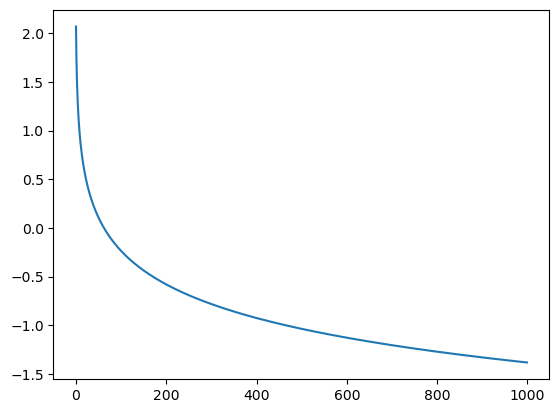

In [26]:
import numpy as np
f = lambda l: 0.5*np.log(2*3.1415) - 0.5*np.log(l)
plt.plot([f(l) for l in np.linspace(0.1, 100, 1000)])